In [1]:
import copy
import glob
import gzip
import json
import os
import shutil
import sys
import time
import warnings
import zipfile
from datetime import date

import cdsapi
import h5py
import numpy
import numpy as np
import pandas as pd
import urllib3
import xarray as xr

sys.path.append(os.getcwd() + "/../cds-backend/code/")
import cds_eua4 as eua

warnings.filterwarnings("ignore")

sys.path.insert(0, os.getcwd() + "/../resort/rasotools-master/")
import matplotlib
import matplotlib.font_manager as font_manager
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
import rasotools
import seaborn

matplotlib.rcParams.update({"font.size": 20})
matplotlib.rcParams["figure.figsize"] = (20, 10)
font = {
    # "family": "normal",
    # 'weight' : 'bold',
    "size": 22,
}
matplotlib.rc("font", **font)

no config found


In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def datetime_to_seconds(dates, ref="1900-01-01T00:00:00"):
    """from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, "s")).astype(np.int64)


def seconds_to_datetime(seconds, ref="1900-01-01"):
    """from seconds to datetime64"""
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit="s", origin=ref, errors="coerce")

In [9]:
with h5py.File('/mnt/users/scratch/leo/scratch/converted_v13/long/0-20001-0-11035_CEUAS_merged_v1.nc', 'r') as fn:
    display(fn['advanced_homogenisation'].keys())

<KeysViewHDF5 ['RAOBCORE_bias_estimate', 'RASE_bias_estimate', 'RICH_bias_estimate', 'RISE_bias_estimate', 'humidity_bias_estimate', 'index', 'latitude_displacement', 'longitude_displacement', 'time_since_launch', 'true_time', 'wind_bias_estimate']>

In [3]:
with open("/users/staff/uvoggenberger/scratch/hug/config_v9/active.json") as json_file:
    active_v9 = json.load(json_file)
with open("/users/staff/uvoggenberger/scratch/hug/config_v11/active.json") as json_file:
    active_v11 = json.load(json_file)

In [2]:
glob.glob('/users/staff/uvoggenberger/scratch/converted_v13/*11035*.nc')

['/users/staff/uvoggenberger/scratch/converted_v13/0-20001-0-11035_CEUAS_merged_v1.nc']

In [3]:
nan_out = []
dc_in = {}
for fi in glob.glob('/users/staff/uvoggenberger/scratch/converted_v13/0-20000-0-20674_CEUAS_merged_v1.nc')[:]:
    nan_out = []
    with h5py.File(fi, 'r') as file:
        print(file['header_table']['product_version'][:10])

[1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4 1.4]


In [ ]:
nan_out = []
dc_in = {}
for fi in glob.glob('/mnt/users/scratch/leo/scratch/converted_v13/1980/0-2000*_CEUAS_merged_v1.nc')[:]:
    nan_out = []
    with h5py.File(fi, 'r') as file:
        if '138' in list(file['recordindices'].keys()):
            # display(file['era5fb'].keys())
            file['recordindices']['138'][:]
            for i in range(len(file['recordindices']['138'][:])-1):
                idx_i = file['recordindices']['138'][i]
                idx_i_p1 = file['recordindices']['138'][i+1]
                if idx_i != idx_i_p1:
                    # print(file['observations_table']['latitude'][idx_i:idx_i_p1])
                    if np.isnan(file['observations_table']['latitude'][idx_i:idx_i_p1]).all():
                        nan_out.append(1)
                        print(i, np.isnan(file['observations_table']['latitude'][idx_i:idx_i_p1]).all())
                        print(i, file['observations_table']['latitude'][idx_i:idx_i_p1])
                        break
                    else:
                        nan_out.append(0)
                else:
                    nan_out.append(2)

In [35]:
nan_out = []
dc_in = {}
for fi in glob.glob('/mnt/users/scratch/leo/scratch/converted_v13/1980/0-2000*_CEUAS_merged_v1.nc')[:1]:
    nan_out = []
    with h5py.File(fi, 'r') as file:
        if '138' in list(file['recordindices'].keys()):
            test = list(file['era5fb'].keys())
            idx = file['recordindices']['138'][:]
            for ti in test:
                try:
                    if np.isnan(file['era5fb'][ti][idx[0]:idx[-1]]).all():
                        print('all nan: ', ti)
                        print(np.shape(file['era5fb'][ti][:]))
                        print()
                    elif np.isnan(file['era5fb'][ti][idx[0]:idx[-1]]).any():
                        print('some nan: ', ti)
                        print(np.shape(file['era5fb'][ti][:]))
                        print()
                    # else:
                    #     print('no nan: ', ti)
                    
                except:
                    print('error: ', ti)
                    print(np.shape(file['era5fb'][ti][:]))
                    print()

some nan:  albedo@modsurf
(180145,)

some nan:  an_depar@body
(180145,)

some nan:  an_depar@surfbody_feedback
(180145,)

some nan:  an_sens_obs@body
(180145,)

some nan:  biascorr@body
(180145,)

some nan:  biascorr_fg@body
(180145,)

some nan:  eda_spread@errstat
(180145,)

error:  expver
(180145, 6)

some nan:  fg_depar@body
(180145,)

some nan:  fg_depar@surfbody_feedback
(180145,)

some nan:  fg_error@errstat
(180145,)

some nan:  final_obs_error@errstat
(180145,)

error:  index
(180145,)

some nan:  lat@hdr
(180145,)

some nan:  lon@hdr
(180145,)

some nan:  lsm@modsurf
(180145,)

all nan:  lsm@surfbody_feedback
(180145,)

some nan:  obs_error@errstat
(180145,)

some nan:  obsvalue@body
(180145,)

some nan:  orography@modsurf
(180145,)

all nan:  ppcode@conv_body
(180145,)

all nan:  qc_pge@body
(180145,)

some nan:  seaice@modsurf
(180145,)

all nan:  sensor@hdr
(180145,)

all nan:  snow_density@surfbody_feedback
(180145,)

some nan:  snow_depth@modsurf
(180145,)

all nan:  snow

In [61]:
nan_out = []
good_counter = []
nan_counter = []
some_nan_counter = []
dc_in = {}
for fi in glob.glob('/mnt/users/scratch/leo/scratch/converted_v13/1980/0-2000*_CEUAS_merged_v1.nc')[:]:
    nan_out = []
    with h5py.File(fi, 'r') as file:
        if '138' in list(file['recordindices'].keys()):
            good_counter.append(0)
            test = list(file['observations_table'].keys())
            idx = file['recordindices']['138'][:]
            for ti in test:
                try:
                    if np.isnan(file['observations_table'][ti][idx[0]:idx[-1]]).all():
                        nan_counter.append([fi,ti])
                        # print('all nan: ', ti)
                        # print(np.shape(file['observations_table'][ti][:]))
                        # print()
                    elif np.isnan(file['observations_table'][ti][idx[0]:idx[-1]]).any():
                        some_nan_counter.append([fi,ti])
                        # print('some nan: ', ti)
                        # print(np.shape(file['observations_table'][ti][:]))
                        # print()
                    # else:
                    #     print('no nan: ', ti)
                    
                except:
                    # print('error: ', ti)
                    # print(np.shape(file['observations_table'][ti][:]))
                    # print()
                    pass

In [ ]:
nan_out = []
good_counter = []
nan_counter = []
some_nan_counter = []
dc_in = {}
for fi in glob.glob('/mnt/users/scratch/leo/scratch/converted_v13/1980/0-2000*_CEUAS_merged_v1.nc')[:]:
    nan_out = []
    with h5py.File(fi, 'r') as file:
        if '138' in list(file['recordindices'].keys()):
            good_counter.append(0)
            test = list(file['observations_table'].keys())
            idx = file['recordindices']['138'][:]
            for ti in test:
                try:
                    if np.isnan(file['observations_table'][ti][idx[0]:idx[-1]]).all():
                        nan_counter.append([fi,ti])
                        # print('all nan: ', ti)
                        # print(np.shape(file['observations_table'][ti][:]))
                        # print()
                    elif np.isnan(file['observations_table'][ti][idx[0]:idx[-1]]).any():
                        some_nan_counter.append([fi,ti])
                        # print('some nan: ', ti)
                        # print(np.shape(file['observations_table'][ti][:]))
                        # print()
                    # else:
                    #     print('no nan: ', ti)
                    
                except:
                    # print('error: ', ti)
                    # print(np.shape(file['observations_table'][ti][:]))
                    # print()
                    pass

In [62]:
len(good_counter)

1239

In [63]:
len(nan_counter)

12390

In [64]:
some_nan_counter

[['/mnt/users/scratch/leo/scratch/converted_v13/1980/0-20000-0-40990_CEUAS_merged_v1.nc',
  'z_coordinate'],
 ['/mnt/users/scratch/leo/scratch/converted_v13/1980/0-20000-0-44354_CEUAS_merged_v1.nc',
  'z_coordinate'],
 ['/mnt/users/scratch/leo/scratch/converted_v13/1980/0-20000-0-51656_CEUAS_merged_v1.nc',
  'z_coordinate'],
 ['/mnt/users/scratch/leo/scratch/converted_v13/1980/0-20000-0-41594_CEUAS_merged_v1.nc',
  'z_coordinate'],
 ['/mnt/users/scratch/leo/scratch/converted_v13/1980/0-20000-0-15480_CEUAS_merged_v1.nc',
  'z_coordinate'],
 ['/mnt/users/scratch/leo/scratch/converted_v13/1980/0-20000-0-61998_CEUAS_merged_v1.nc',
  'z_coordinate'],
 ['/mnt/users/scratch/leo/scratch/converted_v13/1980/0-20001-0-40007_CEUAS_merged_v1.nc',
  'z_coordinate'],
 ['/mnt/users/scratch/leo/scratch/converted_v13/1980/0-20000-0-37548_CEUAS_merged_v1.nc',
  'z_coordinate'],
 ['/mnt/users/scratch/leo/scratch/converted_v13/1980/0-20000-0-41883_CEUAS_merged_v1.nc',
  'z_coordinate'],
 ['/mnt/users/scrat

In [65]:
np.unique(np.array(nan_counter)[:,1])

array(['adjustment_id', 'bbox_max_latitude', 'bbox_max_longitude',
       'bbox_min_latitude', 'bbox_min_longitude', 'location_precision',
       'numerical_precision', 'observation_height_above_station_surface',
       'original_precision', 'original_value'], dtype='<U84')

## CDS API
### Backend

In [152]:
# import cdsapi

# c = cdsapi.Client(
#     url="https://cds-test.copernicus-climate.eu/api/v2",
#     key="2548:a32dce56-b04a-42fc-8fc3-a972f94772ad",
#     progress=True,
#     retry_max=5,
# )
# r = c.retrieve(
#     "insitu-comprehensive-upper-air-observation-network",
#     {
#         "day": ["1"],
#         "format": "csv",
#         "month": "7",
#         "statid": "11035",
#         "pressure_level": ["100"], # USE hPa for CDSAPI! Pa everywhere else!
#         "observed_variable": ["air_temperature"],
#         "year": "1997",
#         "optional": ["obs_minus_bg", "obs_minus_an", "bias_estimate"],
#     },
#     target="download3.zip",
# )

import cdsapi

c = cdsapi.Client()

r = c.retrieve(
    'insitu-observations-igra-baseline-network',
    {
        'archive_type': 'harmonized_global_radiosonde_archive',
        'format': 'csv-lev.zip',
        'year': '2000',
        'month': '01',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
            '13', '14', '15',
            '16', '17', '18',
            '19', '20', '21',
            '22', '23', '24',
            '25', '26', '27',
            '28', '29', '30',
            '31',
        ],
        'area': [
            60, 10, 40,
            20,
        ],
        'variable': [
            'air_temperature', 'eastward_wind_component', 'northward_wind_component',
            'relative_humidity',
        ],
    },
    'download.csv-lev.zip')

2023-07-19 11:42:42,484 INFO Welcome to the CDS
2023-07-19 11:42:42,484 INFO Sending request to https://cds-test.copernicus-climate.eu/api/v2/resources/insitu-observations-igra-baseline-network
2023-07-19 11:42:42,532 INFO Request is queued
2023-07-19 11:42:43,559 INFO Request is completed
2023-07-19 11:42:43,560 INFO Downloading https://cds-test-download-0000.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.insitu_reference.retrieve-1689759763.2069223-31328-1-d402cc8a-aac5-40d6-a0ba-2817bded26f5.zip to download.csv-lev.zip (548.2K)
2023-07-19 11:42:43,779 INFO Download rate 2.4M/s                     


In [157]:
tempdir = "./tmp/"
delete_dl = True
with zipfile.ZipFile("download.csv-lev.zip", "r") as zip_ref:
    try:
        os.mkdir(tempdir)
    except:
        pass

    zip_ref.extractall(tempdir)

for i in glob.glob(tempdir + "*"):
    print(i)
    df = pd.read_csv(i, header=16)

# if delete_dl:
#     shutil.rmtree(tempdir)

./tmp/IGRA_H_20000101_20000131_subset_cdm-lev_v1.csv


In [12]:
glob.glob('/scratch/das/federico/MERGED_FEB2023/*02483*.nc')

['/scratch/das/federico/MERGED_FEB2023/0-20000-0-02483_CEUAS_merged_v1.nc',
 '/scratch/das/federico/MERGED_FEB2023/0-20000-0-02483_CEUAS_merged_v1_beforeSensor.nc']

In [158]:
df

,station_name,radiosonde_code,sensor_model,report_timestamp,actual_time,report_id,longitude,latitude,height_of_station_above_sea_level,air_pressure,air_temperature,relative_humidity,eastward_wind_component,northward_wind_component
0,AUM00011240,61.0,"Vaisala RS80/Loran/Digicora I, II or Marwin (F...",2000-01-01 00:00:00+00,2000-01-01 03:44:00+00,82731,15.4392,46.9931,340.0,10000,215.65,NaN,6.06,-3.50
1,AUM00011240,61.0,"Vaisala RS80/Loran/Digicora I, II or Marwin (F...",2000-01-01 00:00:00+00,2000-01-01 03:44:00+00,82731,15.4392,46.9931,340.0,15000,216.85,NaN,16.74,2.95
2,AUM00011240,61.0,"Vaisala RS80/Loran/Digicora I, II or Marwin (F...",2000-01-01 00:00:00+00,2000-01-01 03:44:00+00,82731,15.4392,46.9931,340.0,20000,216.05,NaN,28.98,7.76
3,AUM00011240,61.0,"Vaisala RS80/Loran/Digicora I, II or Marwin (F...",2000-01-01 00:00:00+00,2000-01-01 03:44:00+00,82731,15.4392,46.9931,340.0,22800,216.45,1.93,45.11,16.42
4,AUM00011240,61.0,"Vaisala RS80/Loran/Digicora I, II or Marwin (F...",2000-01-01 00:00:00+00,2000-01-01 03:44:00+00,82731,15.4392,46.9931,340.0,25000,219.05,2.14,51.68,18.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44295,GMM00010184,62.0,Vaisala RS80/PCCora (Finland),2000-01-31 12:00:00+00,2000-01-31 10:52:00+00,11949459,13.4075,54.0978,2.0,92500,275.66,80.40,7.14,-27.09
44296,GMM00010184,62.0,Vaisala RS80/PCCora (Finland),2000-01-31 12:00:00+00,2000-01-31 10:52:00+00,11949459,13.4075,54.0978,2.0,97400,279.56,62.01,NaN,NaN
44297,GMM00010184,62.0,Vaisala RS80/PCCora (Finland),2000-01-31 12:00:00+00,2000-01-31 10:52:00+00,11949459,13.4075,54.0978,2.0,100000,281.50,65.21,3.48,-17.32
44298,GMM00010771,62.0,Vaisala RS80/PCCora (Finland),2000-01-09 00:00:00+00,2000-01-08 22:47:00+00,5848365,11.9022,49.4283,417.0,96600,272.85,95.02,NaN,NaN


In [159]:
df.station_name.drop_duplicates()

0       AUM00011240
26      AUM00011120
54      GMM00010771
105     DAM00006181
160     PLM00012425
198     ITM00016245
236     HRM00014240
271     PLM00012120
333     ITM00016320
371     ITM00016044
411     AUM00011035
473     GMM00010868
526     EZM00011520
575     GMM00010548
630     HUM00012843
672     GMM00010393
723     GMM00010184
3499    GMM00010962
3623    SWM00002527
4402    SWM00002591
9251    ITM00016144
Name: station_name, dtype: object

## EUA Request
### Backend

### local machine

In [3]:
# rq = {
#     "statid": ["06610"],
#     "variable": ["air_temperature"],
#     "date": "20001231-20010101",
#     "format": "nc",
#     "pressure_level": ["85000"],
#     # "optional": "report_timestamp",
# }
# df_v11 = eua.vm_request_wrapper(rq, overwrite=True, vm_url="http://127.0.0.1:8009")
# df = df_v11.to_dataframe()
# df

### remote VM machine

In [27]:
rq = {
    "statid": ["11035"],
    "variable": ["air_temperature", "relative_humidity", 'dew_point_temperature', "wind_speed", "wind_direction"],
    # "optional": ['humidity_bias_estimate'],
    # "date": "19800103",
    # "date": "20200101",
    # "date": "19800101-19801231",
    # "date": "19800101-19800131",
    # "date": "20200101-20201231",
    # "date": "20200101-20200131",
    #"format": "csv",
    # 'adsfasdf':str(np.random.rand()),
}
df_v11 = eua.vm_request_wrapper(rq, overwrite=True)
df_v11

request took:  359.75607538223267  seconds


CDMDatasetList <5>
- dest_0-20001-0-11035_air_temperature
  File: <HDF5 file "dest_0-20001-0-11035_air_temperature.nc" (mode r)>
  Filesize: 98.08 MB
  Filename: ./dest_0-20001-0-11035_air_temperature.nc
  (G)roups/(V)ariables: 
  
   - V | lat__________________________________________ : : (13042947,)
   - V | lon__________________________________________ : : (13042947,)
   - V | obs__________________________________________ : : (13042947,)
   - V | plev_________________________________________ : : (13042947,)
   - V | report_id____________________________________ : : (13042947, 21)
   - V | station_id___________________________________ : : (13042947, 15)
   - V | ta___________________________________________ : : (13042947,)
   - V | time_________________________________________ : : (13042947,)
- dest_0-20001-0-11035_relative_humidity
  File: <HDF5 file "dest_0-20001-0-11035_relative_humidity.nc" (mode r)>
  Filesize: 23.59 MB
  Filename: ./dest_0-20001-0-11035_relative_humidity.nc
  (

RH
Td


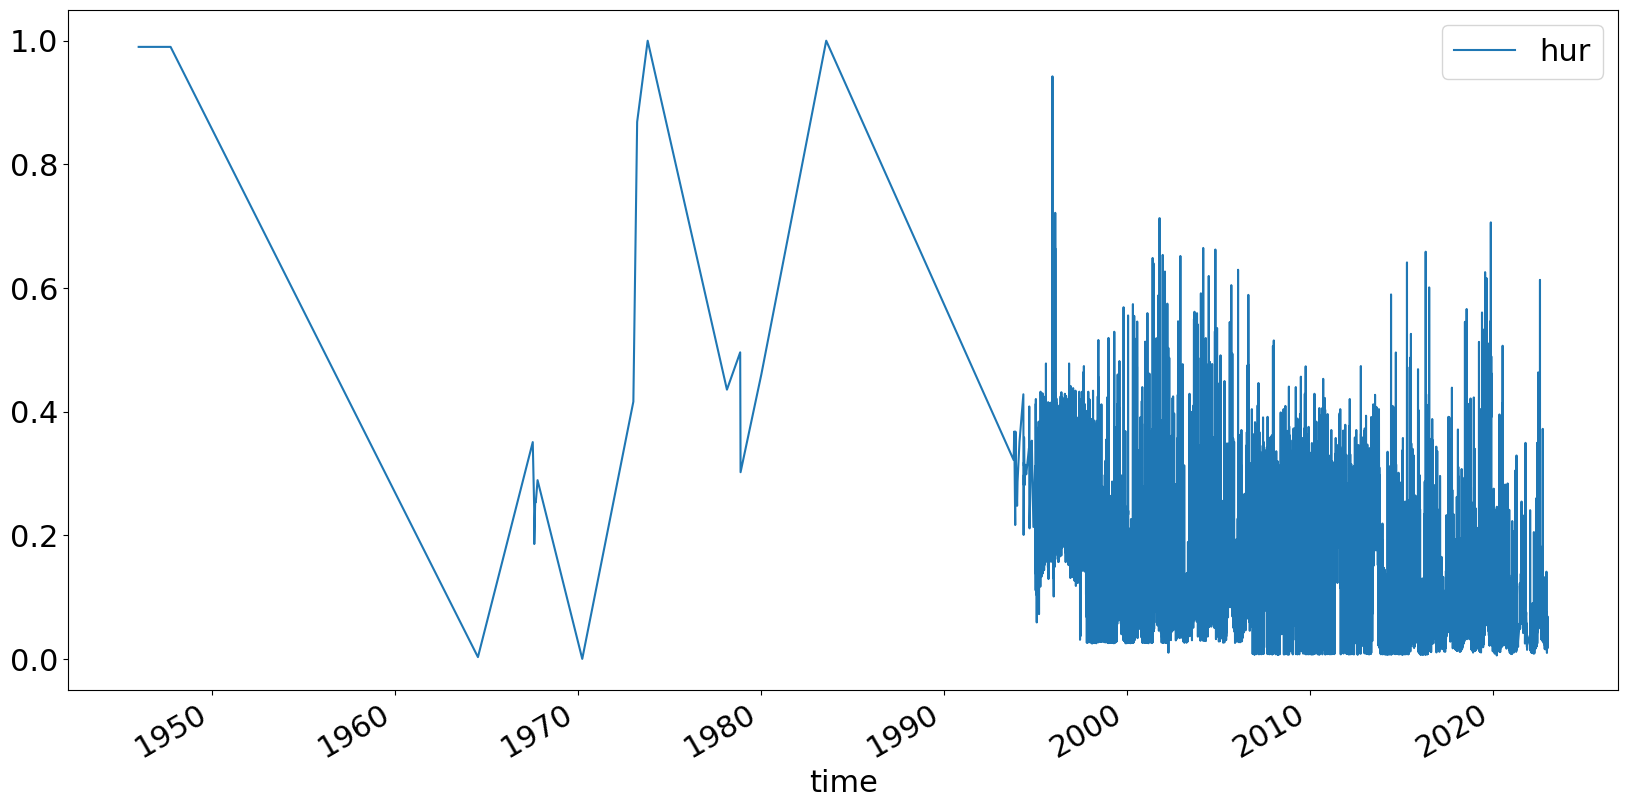

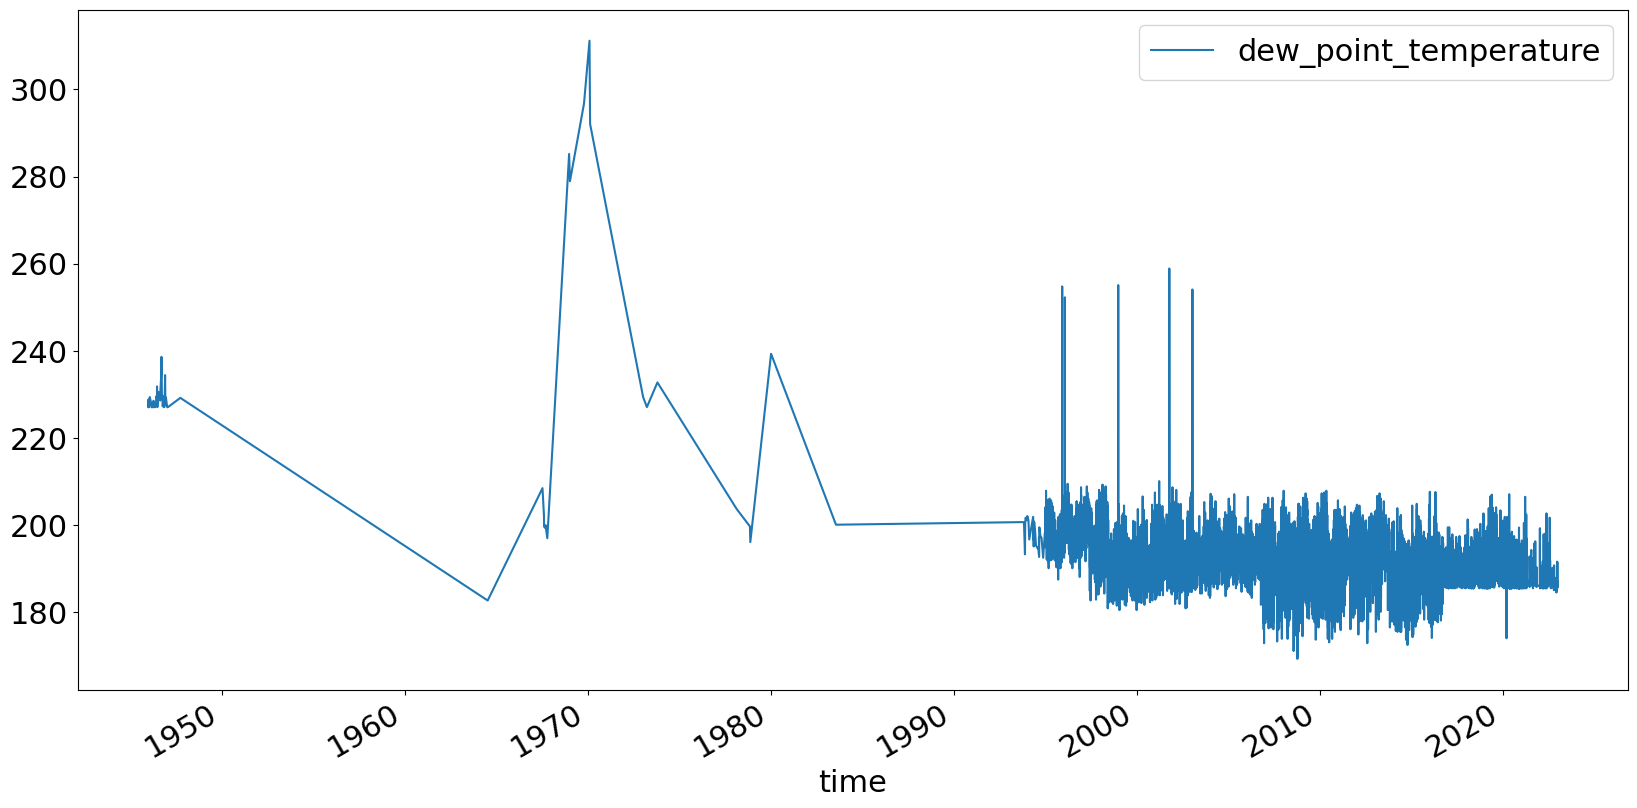

In [5]:
for i in df_v11:
    df = df_v11[i].to_dataframe()
    df_p = df[df.plev == 10000]
    if 'hur' in df.keys():
        print('RH')
        df_p = df_p[df_p['hur'] <= 1]
        #df_p['hur'] = df_p['hur'] - df_p['humidity_bias_estimate']
        df_p.plot(x='time', y='hur')
    else:
        print('Td')
        #df_p['dew_point_temperature'] = df_p['dew_point_temperature'] - df_p['humidity_bias_esitmate']
        df_p.plot(x='time', y='dew_point_temperature')


In [4]:
df

,humidity_bias_estimate,hur,lat,lon,obs,plev,report_id,station_id,time
0,NaN,0.350000,35.180832,-97.437775,0,13200.0,900000000000914,0-20000-0-72357,1928-03-15 13:08:00
1,0.0,0.362306,35.180832,-97.437775,0,15000.0,900000000000914,0-20000-0-72357,1928-03-15 13:08:00
2,0.0,0.390000,35.180832,-97.437775,0,20000.0,900000000000914,0-20000-0-72357,1928-03-15 13:08:00
3,0.0,0.410000,35.180832,-97.437775,0,23600.0,900000000000914,0-20000-0-72357,1928-03-15 13:08:00
4,0.0,0.401436,35.180832,-97.437775,0,25000.0,900000000000914,0-20000-0-72357,1928-03-15 13:08:00
...,...,...,...,...,...,...,...,...,...
3703671,NaN,0.773121,35.180950,-97.437866,0,96690.0,100000000106023,0-20000-0-72357,2022-12-31 11:11:15
3703672,NaN,0.784178,35.180950,-97.437866,0,96760.0,100000000106023,0-20000-0-72357,2022-12-31 11:11:15
3703673,NaN,0.791727,35.180950,-97.437866,0,96830.0,100000000106023,0-20000-0-72357,2022-12-31 11:11:15
3703674,NaN,0.797697,35.180950,-97.437866,0,96890.0,100000000106023,0-20000-0-72357,2022-12-31 11:11:15


In [69]:
df_v11.to_dataframe()

,lat,latitude_displacement,lon,longitude_displacement,obs,plev,report_id,station_id,ta,time,time_since_launch
0,48.23,-0.550382,16.370001,1.161990,0,590.0,100000000075063,0-20001-0-11035,211.300003,2000-01-01 00:00:00,6591.710028
1,48.23,-0.547033,16.370001,1.055423,0,660.0,100000000075063,0-20001-0-11035,209.174515,2000-01-01 00:00:00,6453.719194
2,48.23,-0.540144,16.370001,0.924701,0,760.0,100000000075063,0-20001-0-11035,206.500000,2000-01-01 00:00:00,6282.066679
3,48.23,-0.534732,16.370001,0.720501,0,1000.0,100000000075063,0-20001-0-11035,205.899994,2000-01-01 00:00:00,5950.781114
4,48.23,-0.534730,16.370001,0.702441,0,1030.0,100000000075063,0-20001-0-11035,205.899994,2000-01-01 00:00:00,5915.166609
...,...,...,...,...,...,...,...,...,...,...,...
543,48.23,-0.000092,16.370001,0.000025,0,98500.0,100000000075073,0-20001-0-11035,274.200012,2000-01-03 12:00:00,30.313717
544,48.23,-0.000075,16.370001,-0.000040,0,98700.0,100000000075073,0-20001-0-11035,272.500000,2000-01-03 12:00:00,27.067800
545,48.23,-0.000032,16.370001,-0.000143,0,99400.0,100000000075073,0-20001-0-11035,270.100006,2000-01-03 12:00:00,15.843425
546,48.23,-0.000010,16.370001,-0.000084,0,100000.0,100000000075073,0-20001-0-11035,270.299988,2000-01-03 12:00:00,6.323953


In [10]:
for i in df.time.drop_duplicates():
    df_i = df[df.time == i]
    display(df_i)

,lat,lon,obs,plev,report_id,station_id,ta,time
0,76.519997,-68.830002,0,2000.000000,100000000049682,0-20000-0-04202,231.899994,1980-06-01
1,NaN,NaN,0,2012.560913,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.893814,1980-06-01
2,76.519997,-68.830002,0,3000.000000,100000000049682,0-20000-0-04202,231.500000,1980-06-01
3,NaN,NaN,0,4685.772461,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.801651,1980-06-01
4,NaN,NaN,0,4890.100098,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.734802,1980-06-01
...,...,...,...,...,...,...,...,...
57,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,268.648834,1980-06-01
58,76.519997,-68.830002,0,100000.000000,100000000049682,0-20000-0-04202,270.100006,1980-06-01
59,NaN,NaN,0,100170.484375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.100006,1980-06-01
60,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.100006,1980-06-01


,lat,lon,obs,plev,report_id,station_id,ta,time
62,76.519997,-68.830002,0,3000.000000,100000000049684,0-20000-0-04202,229.699997,1980-06-01 12:00:00
63,NaN,NaN,0,4469.550781,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.948715,1980-06-01 12:00:00
64,NaN,NaN,0,4675.223145,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.089630,1980-06-01 12:00:00
65,NaN,NaN,0,4685.772461,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.096695,1980-06-01 12:00:00
66,NaN,NaN,0,4887.056152,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.228439,1980-06-01 12:00:00
...,...,...,...,...,...,...,...,...
122,76.519997,-68.830002,0,95600.000000,100000000049684,0-20000-0-04202,270.299988,1980-06-01 12:00:00
123,NaN,NaN,0,96100.625000,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.413025,1980-06-01 12:00:00
124,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.787384,1980-06-01 12:00:00
125,NaN,NaN,0,99052.125000,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.067719,1980-06-01 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
127,76.519997,-68.830002,0,15000.000000,100000000049686,0-20000-0-04202,232.100006,1980-06-02
128,NaN,NaN,0,15277.887695,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.112762,1980-06-02
129,NaN,NaN,0,16286.188477,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.157196,1980-06-02
130,NaN,NaN,0,16791.828125,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.178452,1980-06-02
131,76.519997,-68.830002,0,20000.000000,100000000049686,0-20000-0-04202,232.300003,1980-06-02
132,76.519997,-68.830002,0,21900.000000,100000000049686,0-20000-0-04202,234.300003,1980-06-02
133,NaN,NaN,0,23141.087891,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.217422,1980-06-02
134,NaN,NaN,0,24497.517578,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.098740,1980-06-02
135,76.519997,-68.830002,0,25000.000000,100000000049686,0-20000-0-04202,231.699997,1980-06-02
136,NaN,NaN,0,28837.859375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,225.442871,1980-06-02


,lat,lon,obs,plev,report_id,station_id,ta,time
176,76.519997,-68.830002,0,700.000000,100000000049688,0-20000-0-04202,246.899994,1980-06-03
177,76.519997,-68.830002,0,1000.000000,100000000049688,0-20000-0-04202,239.300003,1980-06-03
178,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.250488,1980-06-03
179,76.519997,-68.830002,0,2000.000000,100000000049688,0-20000-0-04202,232.300003,1980-06-03
180,NaN,NaN,0,2027.086304,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.273468,1980-06-03
...,...,...,...,...,...,...,...,...
238,NaN,NaN,0,93455.609375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,267.185242,1980-06-03
239,NaN,NaN,0,94330.804688,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,267.724365,1980-06-03
240,NaN,NaN,0,97097.718750,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,269.396484,1980-06-03
241,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,269.799927,1980-06-03


,lat,lon,obs,plev,report_id,station_id,ta,time
243,76.519997,-68.830002,0,2000.000000,100000000049690,0-20000-0-04202,231.699997,1980-06-03 12:00:00
244,NaN,NaN,0,2025.146118,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.724655,1980-06-03 12:00:00
245,76.519997,-68.830002,0,3000.000000,100000000049690,0-20000-0-04202,232.500000,1980-06-03 12:00:00
246,NaN,NaN,0,4685.772461,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.754120,1980-06-03 12:00:00
247,NaN,NaN,0,4910.766113,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.570496,1980-06-03 12:00:00
248,76.519997,-68.830002,0,5000.000000,100000000049690,0-20000-0-04202,230.500000,1980-06-03 12:00:00
249,76.519997,-68.830002,0,7000.000000,100000000049690,0-20000-0-04202,231.300003,1980-06-03 12:00:00
250,NaN,NaN,0,8262.828125,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.834991,1980-06-03 12:00:00
251,NaN,NaN,0,8379.573242,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.795654,1980-06-03 12:00:00
252,NaN,NaN,0,9983.154297,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.304733,1980-06-03 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
281,76.519997,-68.830002,0,1000.000000,100000000049692,0-20000-0-04202,184.300003,1980-06-04
282,NaN,NaN,0,1736.353516,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.613190,1980-06-04
283,76.519997,-68.830002,0,1800.000000,100000000049692,0-20000-0-04202,234.699997,1980-06-04
284,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.614624,1980-06-04
285,NaN,NaN,0,1943.664917,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.116943,1980-06-04
...,...,...,...,...,...,...,...,...
347,NaN,NaN,0,94330.804688,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,267.325623,1980-06-04
348,NaN,NaN,0,97347.625000,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.224579,1980-06-04
349,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.630127,1980-06-04
350,76.519997,-68.830002,0,100000.000000,100000000049692,0-20000-0-04202,272.700012,1980-06-04


,lat,lon,obs,plev,report_id,station_id,ta,time
352,76.519997,-68.75,0,1000.0,100000000049693,0-20000-0-04202,241.300003,1980-06-04 11:00:00
353,76.519997,-68.75,0,2000.0,100000000049693,0-20000-0-04202,234.500000,1980-06-04 11:00:00
354,76.519997,-68.75,0,3000.0,100000000049693,0-20000-0-04202,233.100006,1980-06-04 11:00:00
355,76.519997,-68.75,0,5000.0,100000000049693,0-20000-0-04202,231.500000,1980-06-04 11:00:00
356,76.519997,-68.75,0,7000.0,100000000049693,0-20000-0-04202,230.699997,1980-06-04 11:00:00
357,76.519997,-68.75,0,10000.0,100000000049693,0-20000-0-04202,230.500000,1980-06-04 11:00:00
358,NaN,NaN,0,11550.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.419128,1980-06-04 11:00:00
359,76.519997,-68.75,0,15000.0,100000000049693,0-20000-0-04202,235.899994,1980-06-04 11:00:00
360,76.519997,-68.75,0,20000.0,100000000049693,0-20000-0-04202,235.699997,1980-06-04 11:00:00
361,NaN,NaN,0,22440.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,235.906357,1980-06-04 11:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
396,76.519997,-68.830002,0,2000.000000,100000000049696,0-20000-0-04202,232.300003,1980-06-05
397,NaN,NaN,0,2128.066406,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.330612,1980-06-05
398,76.519997,-68.830002,0,3000.000000,100000000049696,0-20000-0-04202,232.500000,1980-06-05
399,NaN,NaN,0,4685.772461,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.976227,1980-06-05
400,NaN,NaN,0,4936.835449,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.914932,1980-06-05
401,76.519997,-68.830002,0,5000.000000,100000000049696,0-20000-0-04202,231.899994,1980-06-05
402,76.519997,-68.830002,0,7000.000000,100000000049696,0-20000-0-04202,230.500000,1980-06-05
403,76.519997,-68.830002,0,10000.000000,100000000049696,0-20000-0-04202,231.699997,1980-06-05
404,NaN,NaN,0,11964.492188,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.673172,1980-06-05
405,NaN,NaN,0,12061.655273,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.717056,1980-06-05


,lat,lon,obs,plev,report_id,station_id,ta,time
456,76.519997,-68.830002,0,41900.0,100000000049698,0-20000-0-04202,229.300003,1980-06-05 12:00:00
457,76.519997,-68.830002,0,44900.0,100000000049698,0-20000-0-04202,233.500000,1980-06-05 12:00:00
458,76.519997,-68.830002,0,50000.0,100000000049698,0-20000-0-04202,238.500000,1980-06-05 12:00:00
459,76.519997,-68.830002,0,64900.0,100000000049698,0-20000-0-04202,250.500000,1980-06-05 12:00:00
460,76.519997,-68.830002,0,70000.0,100000000049698,0-20000-0-04202,251.899994,1980-06-05 12:00:00
461,76.519997,-68.830002,0,72300.0,100000000049698,0-20000-0-04202,252.699997,1980-06-05 12:00:00
462,76.519997,-68.830002,0,85000.0,100000000049698,0-20000-0-04202,261.299988,1980-06-05 12:00:00
463,76.519997,-68.830002,0,90100.0,100000000049698,0-20000-0-04202,263.500000,1980-06-05 12:00:00
464,NaN,NaN,0,92500.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,265.431702,1980-06-05 12:00:00
465,76.519997,-68.830002,0,95400.0,100000000049698,0-20000-0-04202,267.700012,1980-06-05 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
468,76.519997,-68.75,0,44600.0,100000000049699,0-20000-0-04202,234.500000,1980-06-05 23:00:00
469,NaN,NaN,0,46730.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,236.541000,1980-06-05 23:00:00
470,76.519997,-68.75,0,50000.0,100000000049699,0-20000-0-04202,239.500000,1980-06-05 23:00:00
471,76.519997,-68.75,0,52000.0,100000000049699,0-20000-0-04202,241.100006,1980-06-05 23:00:00
472,NaN,NaN,0,53290.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,242.210175,1980-06-05 23:00:00
473,76.519997,-68.75,0,56800.0,100000000049699,0-20000-0-04202,245.100006,1980-06-05 23:00:00
474,NaN,NaN,0,58030.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,246.192383,1980-06-05 23:00:00
475,NaN,NaN,0,63100.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,250.463104,1980-06-05 23:00:00
476,76.519997,-68.75,0,67500.0,100000000049699,0-20000-0-04202,253.899994,1980-06-05 23:00:00
477,76.519997,-68.75,0,70000.0,100000000049699,0-20000-0-04202,254.500000,1980-06-05 23:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
491,76.519997,-68.75,0,1000.0,100000000049701,0-20000-0-04202,241.699997,1980-06-06 11:00:00
492,76.519997,-68.75,0,2000.0,100000000049701,0-20000-0-04202,232.699997,1980-06-06 11:00:00
493,76.519997,-68.75,0,3000.0,100000000049701,0-20000-0-04202,233.100006,1980-06-06 11:00:00
494,76.519997,-68.75,0,5000.0,100000000049701,0-20000-0-04202,232.100006,1980-06-06 11:00:00
495,76.519997,-68.75,0,7000.0,100000000049701,0-20000-0-04202,232.100006,1980-06-06 11:00:00
496,76.519997,-68.75,0,10000.0,100000000049701,0-20000-0-04202,233.100006,1980-06-06 11:00:00
497,NaN,NaN,0,11690.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.485107,1980-06-06 11:00:00
498,76.519997,-68.75,0,15000.0,100000000049701,0-20000-0-04202,234.100006,1980-06-06 11:00:00
499,76.519997,-68.75,0,20000.0,100000000049701,0-20000-0-04202,233.300003,1980-06-06 11:00:00
500,76.519997,-68.75,0,20400.0,100000000049701,0-20000-0-04202,234.899994,1980-06-06 11:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
535,76.519997,-68.830002,0,2000.000000,100000000049704,0-20000-0-04202,232.100006,1980-06-07
536,NaN,NaN,0,2045.159912,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.044937,1980-06-07
537,76.519997,-68.830002,0,3000.000000,100000000049704,0-20000-0-04202,231.100006,1980-06-07
538,NaN,NaN,0,4685.772461,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.449173,1980-06-07
539,NaN,NaN,0,4953.750488,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.492722,1980-06-07
...,...,...,...,...,...,...,...,...
594,NaN,NaN,0,98005.132812,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,268.872101,1980-06-07
595,76.519997,-68.830002,0,100000.000000,100000000049704,0-20000-0-04202,270.500000,1980-06-07
596,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.949799,1980-06-07
597,NaN,NaN,0,101025.664062,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.246155,1980-06-07


,lat,lon,obs,plev,report_id,station_id,ta,time
599,76.519997,-68.830002,0,1000.000000,100000000049706,0-20000-0-04202,241.899994,1980-06-07 12:00:00
600,76.519997,-68.830002,0,2000.000000,100000000049706,0-20000-0-04202,234.100006,1980-06-07 12:00:00
601,76.519997,-68.830002,0,3000.000000,100000000049706,0-20000-0-04202,232.100006,1980-06-07 12:00:00
602,76.519997,-68.830002,0,4550.000000,100000000049706,0-20000-0-04202,244.100006,1980-06-07 12:00:00
603,76.519997,-68.830002,0,5000.000000,100000000049706,0-20000-0-04202,232.699997,1980-06-07 12:00:00
604,76.519997,-68.830002,0,7000.000000,100000000049706,0-20000-0-04202,232.699997,1980-06-07 12:00:00
605,76.519997,-68.830002,0,10000.000000,100000000049706,0-20000-0-04202,232.500000,1980-06-07 12:00:00
606,NaN,NaN,0,11955.555664,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.204819,1980-06-07 12:00:00
607,NaN,NaN,0,12061.655273,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.239685,1980-06-07 12:00:00
608,76.519997,-68.830002,0,15000.000000,100000000049706,0-20000-0-04202,234.100006,1980-06-07 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
656,76.519997,-68.830002,0,1000.000000,100000000049708,0-20000-0-04202,240.100006,1980-06-08
657,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.359116,1980-06-08
658,76.519997,-68.830002,0,2000.000000,100000000049708,0-20000-0-04202,232.300003,1980-06-08
659,NaN,NaN,0,2044.164673,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.278458,1980-06-08
660,76.519997,-68.830002,0,3000.000000,100000000049708,0-20000-0-04202,231.899994,1980-06-08
...,...,...,...,...,...,...,...,...
712,NaN,NaN,0,93109.812500,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,265.355621,1980-06-08
713,NaN,NaN,0,94330.804688,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,266.221375,1980-06-08
714,NaN,NaN,0,96731.546875,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,267.891449,1980-06-08
715,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,268.605988,1980-06-08


,lat,lon,obs,plev,report_id,station_id,ta,time
717,76.519997,-68.75,0,500.0,100000000049709,0-20000-0-04202,239.500000,1980-06-08 11:00:00
718,76.519997,-68.75,0,700.0,100000000049709,0-20000-0-04202,238.100006,1980-06-08 11:00:00
719,76.519997,-68.75,0,1000.0,100000000049709,0-20000-0-04202,236.699997,1980-06-08 11:00:00
720,76.519997,-68.75,0,2000.0,100000000049709,0-20000-0-04202,232.899994,1980-06-08 11:00:00
721,76.519997,-68.75,0,3000.0,100000000049709,0-20000-0-04202,233.100006,1980-06-08 11:00:00
722,76.519997,-68.75,0,5000.0,100000000049709,0-20000-0-04202,231.500000,1980-06-08 11:00:00
723,76.519997,-68.75,0,7000.0,100000000049709,0-20000-0-04202,231.899994,1980-06-08 11:00:00
724,76.519997,-68.75,0,10000.0,100000000049709,0-20000-0-04202,231.899994,1980-06-08 11:00:00
725,NaN,NaN,0,11610.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.709976,1980-06-08 11:00:00
726,NaN,NaN,0,13880.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.678955,1980-06-08 11:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
766,76.532997,-68.75,0,10000.000000,300000000049712,0-20000-0-04202,230.850006,1980-06-09
767,NaN,NaN,0,11614.048828,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.366653,1980-06-09
768,NaN,NaN,0,14075.939453,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.030457,1980-06-09
769,76.532997,-68.75,0,15000.000000,300000000049712,0-20000-0-04202,232.250000,1980-06-09
770,76.532997,-68.75,0,20000.000000,300000000049712,0-20000-0-04202,233.850006,1980-06-09
771,NaN,NaN,0,23865.332031,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.899780,1980-06-09
772,76.532997,-68.75,0,25000.000000,300000000049712,0-20000-0-04202,232.649994,1980-06-09
773,76.532997,-68.75,0,30000.000000,300000000049712,0-20000-0-04202,226.649994,1980-06-09
774,NaN,NaN,0,30113.980469,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,226.482758,1980-06-09
775,76.532997,-68.75,0,32700.000000,300000000049712,0-20000-0-04202,222.850006,1980-06-09


,lat,lon,obs,plev,report_id,station_id,ta,time
802,76.519997,-68.830002,0,2000.000000,100000000049714,0-20000-0-04202,233.100006,1980-06-09 12:00:00
803,NaN,NaN,0,2047.523804,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.088425,1980-06-09 12:00:00
804,76.519997,-68.830002,0,3000.000000,100000000049714,0-20000-0-04202,232.899994,1980-06-09 12:00:00
805,NaN,NaN,0,4685.772461,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.899994,1980-06-09 12:00:00
806,NaN,NaN,0,4974.681641,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.899994,1980-06-09 12:00:00
...,...,...,...,...,...,...,...,...
861,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,269.431793,1980-06-09 12:00:00
862,NaN,NaN,0,97817.867188,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,269.444122,1980-06-09 12:00:00
863,76.519997,-68.830002,0,100000.000000,100000000049714,0-20000-0-04202,270.100006,1980-06-09 12:00:00
864,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,267.784302,1980-06-09 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
866,76.519997,-68.830002,0,1000.000000,100000000049716,0-20000-0-04202,241.500000,1980-06-10
867,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.067719,1980-06-10
868,76.519997,-68.830002,0,2000.000000,100000000049716,0-20000-0-04202,232.899994,1980-06-10
869,NaN,NaN,0,2056.243652,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.845276,1980-06-10
870,76.519997,-68.830002,0,3000.000000,100000000049716,0-20000-0-04202,232.100006,1980-06-10
...,...,...,...,...,...,...,...,...
927,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.305267,1980-06-10
928,NaN,NaN,0,98538.507812,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.786438,1980-06-10
929,76.519997,-68.830002,0,100000.000000,100000000049716,0-20000-0-04202,272.700012,1980-06-10
930,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.617371,1980-06-10


,lat,lon,obs,plev,report_id,station_id,ta,time
932,76.519997,-68.830002,0,2000.000000,100000000049718,0-20000-0-04202,232.100006,1980-06-10 12:00:00
933,76.519997,-68.830002,0,2500.000000,100000000049718,0-20000-0-04202,231.100006,1980-06-10 12:00:00
934,NaN,NaN,0,2534.233154,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.076462,1980-06-10 12:00:00
935,NaN,NaN,0,2803.530029,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.901627,1980-06-10 12:00:00
936,NaN,NaN,0,3000.000000,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.784363,1980-06-10 12:00:00
...,...,...,...,...,...,...,...,...
991,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,268.278870,1980-06-10 12:00:00
992,NaN,NaN,0,98292.367188,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,268.377319,1980-06-10 12:00:00
993,76.519997,-68.830002,0,100000.000000,100000000049718,0-20000-0-04202,268.700012,1980-06-10 12:00:00
994,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,269.842957,1980-06-10 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
996,76.519997,-68.830002,0,1000.000000,100000000049720,0-20000-0-04202,242.300003,1980-06-11
997,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.657837,1980-06-11
998,76.519997,-68.830002,0,2000.000000,100000000049720,0-20000-0-04202,232.300003,1980-06-11
999,NaN,NaN,0,2057.392822,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.216263,1980-06-11
1000,76.519997,-68.830002,0,3000.000000,100000000049720,0-20000-0-04202,231.100006,1980-06-11
...,...,...,...,...,...,...,...,...
1058,NaN,NaN,0,97828.812500,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.399536,1980-06-11
1059,76.519997,-68.830002,0,100000.000000,100000000049720,0-20000-0-04202,272.100006,1980-06-11
1060,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.511932,1980-06-11
1061,NaN,NaN,0,100827.164062,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.651672,1980-06-11


,lat,lon,obs,plev,report_id,station_id,ta,time
1063,76.519997,-68.830002,0,500.000000,100000000049722,0-20000-0-04202,242.899994,1980-06-11 12:00:00
1064,76.519997,-68.830002,0,700.000000,100000000049722,0-20000-0-04202,242.699997,1980-06-11 12:00:00
1065,76.519997,-68.830002,0,1000.000000,100000000049722,0-20000-0-04202,237.899994,1980-06-11 12:00:00
1066,76.519997,-68.830002,0,1150.000000,100000000049722,0-20000-0-04202,238.899994,1980-06-11 12:00:00
1067,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.426590,1980-06-11 12:00:00
1068,76.519997,-68.830002,0,2000.000000,100000000049722,0-20000-0-04202,231.100006,1980-06-11 12:00:00
1069,NaN,NaN,0,2050.711914,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.087662,1980-06-11 12:00:00
1070,76.519997,-68.830002,0,3000.000000,100000000049722,0-20000-0-04202,230.899994,1980-06-11 12:00:00
1071,NaN,NaN,0,4685.772461,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,229.852478,1980-06-11 12:00:00
1072,NaN,NaN,0,4991.060547,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,229.704193,1980-06-11 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
1117,76.519997,-68.830002,0,700.000000,100000000049724,0-20000-0-04202,246.300003,1980-06-12
1118,76.519997,-68.830002,0,1000.000000,100000000049724,0-20000-0-04202,240.100006,1980-06-12
1119,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.013412,1980-06-12
1120,76.519997,-68.830002,0,2000.000000,100000000049724,0-20000-0-04202,231.899994,1980-06-12
1121,NaN,NaN,0,2056.662598,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.899994,1980-06-12
...,...,...,...,...,...,...,...,...
1177,NaN,NaN,0,97959.023438,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.997040,1980-06-12
1178,76.519997,-68.830002,0,100000.000000,100000000049724,0-20000-0-04202,273.399994,1980-06-12
1179,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,273.894562,1980-06-12
1180,NaN,NaN,0,100956.671875,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,274.165497,1980-06-12


,lat,lon,obs,plev,report_id,station_id,ta,time
1182,76.519997,-68.830002,0,1000.000000,100000000049726,0-20000-0-04202,242.500000,1980-06-12 12:00:00
1183,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.376358,1980-06-12 12:00:00
1184,76.519997,-68.830002,0,2000.000000,100000000049726,0-20000-0-04202,233.100006,1980-06-12 12:00:00
1185,NaN,NaN,0,2050.802734,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.075256,1980-06-12 12:00:00
1186,76.519997,-68.830002,0,3000.000000,100000000049726,0-20000-0-04202,232.699997,1980-06-12 12:00:00
1187,NaN,NaN,0,4685.772461,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.954132,1980-06-12 12:00:00
1188,NaN,NaN,0,4983.476074,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.712967,1980-06-12 12:00:00
1189,76.519997,-68.830002,0,5000.000000,100000000049726,0-20000-0-04202,230.699997,1980-06-12 12:00:00
1190,76.519997,-68.830002,0,7000.000000,100000000049726,0-20000-0-04202,230.699997,1980-06-12 12:00:00
1191,76.519997,-68.830002,0,10000.000000,100000000049726,0-20000-0-04202,230.899994,1980-06-12 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
1241,76.519997,-68.830002,0,700.000000,100000000049728,0-20000-0-04202,247.100006,1980-06-13
1242,76.519997,-68.830002,0,1000.000000,100000000049728,0-20000-0-04202,241.899994,1980-06-13
1243,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.739288,1980-06-13
1244,76.519997,-68.830002,0,2000.000000,100000000049728,0-20000-0-04202,231.300003,1980-06-13
1245,NaN,NaN,0,2055.615479,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.354126,1980-06-13
...,...,...,...,...,...,...,...,...
1308,NaN,NaN,0,94330.804688,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,267.812714,1980-06-13
1309,76.519997,-68.830002,0,94500.000000,100000000049728,0-20000-0-04202,267.899994,1980-06-13
1310,NaN,NaN,0,97019.539062,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.039612,1980-06-13
1311,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.672241,1980-06-13


,lat,lon,obs,plev,report_id,station_id,ta,time
1313,76.519997,-68.830002,0,1000.000000,100000000049730,0-20000-0-04202,239.500000,1980-06-13 12:00:00
1314,NaN,NaN,0,1506.663940,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.414322,1980-06-13 12:00:00
1315,NaN,NaN,0,1717.528198,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.789139,1980-06-13 12:00:00
1316,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.067734,1980-06-13 12:00:00
1317,76.519997,-68.830002,0,2000.000000,100000000049730,0-20000-0-04202,230.899994,1980-06-13 12:00:00
1318,NaN,NaN,0,2049.189941,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.840073,1980-06-13 12:00:00
1319,76.519997,-68.830002,0,3000.000000,100000000049730,0-20000-0-04202,229.899994,1980-06-13 12:00:00
1320,76.519997,-68.830002,0,4300.000000,100000000049730,0-20000-0-04202,242.699997,1980-06-13 12:00:00
1321,NaN,NaN,0,4685.772461,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.724945,1980-06-13 12:00:00
1322,NaN,NaN,0,4977.988281,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,229.109497,1980-06-13 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
1373,76.519997,-68.830002,0,2000.000000,100000000049732,0-20000-0-04202,231.699997,1980-06-14
1374,NaN,NaN,0,2053.316162,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.764877,1980-06-14
1375,76.519997,-68.830002,0,3000.000000,100000000049732,0-20000-0-04202,232.699997,1980-06-14
1376,NaN,NaN,0,4685.772461,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.128708,1980-06-14
1377,NaN,NaN,0,4984.862305,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.910675,1980-06-14
...,...,...,...,...,...,...,...,...
1432,NaN,NaN,0,93207.078125,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.868561,1980-06-14
1433,NaN,NaN,0,94330.804688,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.398102,1980-06-14
1434,NaN,NaN,0,96781.804688,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,273.531616,1980-06-14
1435,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,273.983826,1980-06-14


,lat,lon,obs,plev,report_id,station_id,ta,time
1437,76.519997,-68.75,0,600.0,100000000049733,0-20000-0-04202,247.300003,1980-06-14 11:00:00
1438,76.519997,-68.75,0,700.0,100000000049733,0-20000-0-04202,245.100006,1980-06-14 11:00:00
1439,76.519997,-68.75,0,1000.0,100000000049733,0-20000-0-04202,240.100006,1980-06-14 11:00:00
1440,76.519997,-68.75,0,2000.0,100000000049733,0-20000-0-04202,230.699997,1980-06-14 11:00:00
1441,76.519997,-68.75,0,3000.0,100000000049733,0-20000-0-04202,232.300003,1980-06-14 11:00:00
1442,76.519997,-68.75,0,5000.0,100000000049733,0-20000-0-04202,230.699997,1980-06-14 11:00:00
1443,76.519997,-68.75,0,7000.0,100000000049733,0-20000-0-04202,230.100006,1980-06-14 11:00:00
1444,76.519997,-68.75,0,8600.0,100000000049733,0-20000-0-04202,232.100006,1980-06-14 11:00:00
1445,NaN,NaN,0,10000.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.619461,1980-06-14 11:00:00
1446,NaN,NaN,0,11620.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.141083,1980-06-14 11:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
1483,76.519997,-68.830002,0,1000.000000,100000000049736,0-20000-0-04202,241.100006,1980-06-15
1484,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.803513,1980-06-15
1485,76.519997,-68.830002,0,2000.000000,100000000049736,0-20000-0-04202,231.500000,1980-06-15
1486,NaN,NaN,0,2057.505615,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.569916,1980-06-15
1487,76.519997,-68.830002,0,3000.000000,100000000049736,0-20000-0-04202,232.500000,1980-06-15
...,...,...,...,...,...,...,...,...
1540,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.136566,1980-06-15
1541,76.519997,-68.830002,0,97900.000000,100000000049736,0-20000-0-04202,271.100006,1980-06-15
1542,76.519997,-68.830002,0,100000.000000,100000000049736,0-20000-0-04202,270.899994,1980-06-15
1543,NaN,NaN,0,100067.078125,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.704956,1980-06-15


,lat,lon,obs,plev,report_id,station_id,ta,time
1545,76.519997,-68.830002,0,2000.000000,100000000049738,0-20000-0-04202,230.500000,1980-06-15 12:00:00
1546,NaN,NaN,0,2051.175781,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.512466,1980-06-15 12:00:00
1547,76.519997,-68.830002,0,3000.000000,100000000049738,0-20000-0-04202,230.699997,1980-06-15 12:00:00
1548,NaN,NaN,0,4685.772461,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.525406,1980-06-15 12:00:00
1549,NaN,NaN,0,4986.770020,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.501038,1980-06-15 12:00:00
...,...,...,...,...,...,...,...,...
1605,NaN,NaN,0,96860.445312,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,268.768555,1980-06-15 12:00:00
1606,76.519997,-68.830002,0,97100.000000,100000000049738,0-20000-0-04202,268.700012,1980-06-15 12:00:00
1607,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,269.531403,1980-06-15 12:00:00
1608,NaN,NaN,0,99817.226562,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.000885,1980-06-15 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
1610,76.519997,-68.830002,0,1000.000000,100000000049740,0-20000-0-04202,238.100006,1980-06-16
1611,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.778931,1980-06-16
1612,76.519997,-68.830002,0,2000.000000,100000000049740,0-20000-0-04202,233.100006,1980-06-16
1613,NaN,NaN,0,2060.380127,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.070663,1980-06-16
1614,76.519997,-68.830002,0,3000.000000,100000000049740,0-20000-0-04202,232.699997,1980-06-16
...,...,...,...,...,...,...,...,...
1667,NaN,NaN,0,94330.804688,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.897156,1980-06-16
1668,76.519997,-68.830002,0,96500.000000,100000000049740,0-20000-0-04202,272.700012,1980-06-16
1669,NaN,NaN,0,97155.148438,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.794952,1980-06-16
1670,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.884552,1980-06-16


,lat,lon,obs,plev,report_id,station_id,ta,time
1672,76.519997,-68.830002,0,500.000000,100000000049742,0-20000-0-04202,253.899994,1980-06-16 12:00:00
1673,76.519997,-68.830002,0,1000.000000,100000000049742,0-20000-0-04202,241.100006,1980-06-16 12:00:00
1674,NaN,NaN,0,1307.568359,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,237.927536,1980-06-16 12:00:00
1675,NaN,NaN,0,1515.956665,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,236.178131,1980-06-16 12:00:00
1676,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.013412,1980-06-16 12:00:00
...,...,...,...,...,...,...,...,...
1740,76.519997,-68.830002,0,97100.000000,100000000049742,0-20000-0-04202,270.700012,1980-06-16 12:00:00
1741,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.172424,1980-06-16 12:00:00
1742,76.519997,-68.830002,0,100000.000000,100000000049742,0-20000-0-04202,272.700012,1980-06-16 12:00:00
1743,NaN,NaN,0,100037.390625,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.475586,1980-06-16 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
1745,76.519997,-68.75,0,1450.0,100000000049743,0-20000-0-04202,236.500000,1980-06-16 23:00:00
1746,76.519997,-68.75,0,2000.0,100000000049743,0-20000-0-04202,231.300003,1980-06-16 23:00:00
1747,76.519997,-68.75,0,3000.0,100000000049743,0-20000-0-04202,231.699997,1980-06-16 23:00:00
1748,76.519997,-68.75,0,5000.0,100000000049743,0-20000-0-04202,230.100006,1980-06-16 23:00:00
1749,76.519997,-68.75,0,7000.0,100000000049743,0-20000-0-04202,231.100006,1980-06-16 23:00:00
1750,76.519997,-68.75,0,10000.0,100000000049743,0-20000-0-04202,230.699997,1980-06-16 23:00:00
1751,76.519997,-68.75,0,11400.0,100000000049743,0-20000-0-04202,228.699997,1980-06-16 23:00:00
1752,76.519997,-68.75,0,15000.0,100000000049743,0-20000-0-04202,230.699997,1980-06-16 23:00:00
1753,76.519997,-68.75,0,20000.0,100000000049743,0-20000-0-04202,231.699997,1980-06-16 23:00:00
1754,76.519997,-68.75,0,25000.0,100000000049743,0-20000-0-04202,232.500000,1980-06-16 23:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
1767,76.519997,-68.830002,0,7000.000000,100000000049746,0-20000-0-04202,230.699997,1980-06-17 12:00:00
1768,NaN,NaN,0,8262.828125,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.421005,1980-06-17 12:00:00
1769,NaN,NaN,0,8532.390625,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.367004,1980-06-17 12:00:00
1770,76.519997,-68.830002,0,10000.000000,100000000049746,0-20000-0-04202,230.100006,1980-06-17 12:00:00
1771,NaN,NaN,0,12061.655273,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,229.637695,1980-06-17 12:00:00
1772,NaN,NaN,0,12199.965820,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,229.609573,1980-06-17 12:00:00
1773,76.519997,-68.830002,0,15000.000000,100000000049746,0-20000-0-04202,229.100006,1980-06-17 12:00:00
1774,76.519997,-68.830002,0,20000.000000,100000000049746,0-20000-0-04202,230.100006,1980-06-17 12:00:00
1775,76.519997,-68.830002,0,22300.000000,100000000049746,0-20000-0-04202,230.100006,1980-06-17 12:00:00
1776,NaN,NaN,0,23813.894531,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,229.180466,1980-06-17 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
1821,76.519997,-68.830002,0,700.000000,100000000049748,0-20000-0-04202,250.699997,1980-06-18
1822,76.519997,-68.830002,0,1000.000000,100000000049748,0-20000-0-04202,241.899994,1980-06-18
1823,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.430664,1980-06-18
1824,76.519997,-68.830002,0,2000.000000,100000000049748,0-20000-0-04202,232.100006,1980-06-18
1825,NaN,NaN,0,2063.054199,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.038757,1980-06-18
...,...,...,...,...,...,...,...,...
1878,NaN,NaN,0,96774.015625,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.993988,1980-06-18
1879,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.940552,1980-06-18
1880,76.519997,-68.830002,0,98200.000000,100000000049748,0-20000-0-04202,270.500000,1980-06-18
1881,NaN,NaN,0,99701.632812,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.438995,1980-06-18


,lat,lon,obs,plev,report_id,station_id,ta,time
1883,76.519997,-68.830002,0,700.000000,100000000049750,0-20000-0-04202,247.699997,1980-06-18 12:00:00
1884,76.519997,-68.830002,0,1000.000000,100000000049750,0-20000-0-04202,242.500000,1980-06-18 12:00:00
1885,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.376358,1980-06-18 12:00:00
1886,76.519997,-68.830002,0,2000.000000,100000000049750,0-20000-0-04202,233.100006,1980-06-18 12:00:00
1887,NaN,NaN,0,2059.939941,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.085434,1980-06-18 12:00:00
...,...,...,...,...,...,...,...,...
1941,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,276.348541,1980-06-18 12:00:00
1942,76.519997,-68.830002,0,98000.000000,100000000049750,0-20000-0-04202,276.200012,1980-06-18 12:00:00
1943,76.519997,-68.830002,0,98800.000000,100000000049750,0-20000-0-04202,272.700012,1980-06-18 12:00:00
1944,76.519997,-68.830002,0,99100.000000,100000000049750,0-20000-0-04202,271.500000,1980-06-18 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
1946,76.519997,-68.830002,0,2000.000000,100000000049752,0-20000-0-04202,233.699997,1980-06-19
1947,NaN,NaN,0,2064.841064,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.558350,1980-06-19
1948,76.519997,-68.830002,0,3000.000000,100000000049752,0-20000-0-04202,231.899994,1980-06-19
1949,NaN,NaN,0,4685.772461,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.677887,1980-06-19
1950,76.519997,-68.830002,0,5000.000000,100000000049752,0-20000-0-04202,230.500000,1980-06-19
...,...,...,...,...,...,...,...,...
2002,NaN,NaN,0,97248.820312,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.572632,1980-06-19
2003,76.519997,-68.830002,0,97500.000000,100000000049752,0-20000-0-04202,270.899994,1980-06-19
2004,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.180450,1980-06-19
2005,76.519997,-68.830002,0,100000.000000,100000000049752,0-20000-0-04202,273.399994,1980-06-19


,lat,lon,obs,plev,report_id,station_id,ta,time
2007,76.519997,-68.830002,0,1000.000000,100000000049754,0-20000-0-04202,241.899994,1980-06-19 12:00:00
2008,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.813416,1980-06-19 12:00:00
2009,76.519997,-68.830002,0,2000.000000,100000000049754,0-20000-0-04202,233.699997,1980-06-19 12:00:00
2010,NaN,NaN,0,2068.096191,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.534851,1980-06-19 12:00:00
2011,76.519997,-68.830002,0,3000.000000,100000000049754,0-20000-0-04202,231.699997,1980-06-19 12:00:00
...,...,...,...,...,...,...,...,...
2068,76.519997,-68.830002,0,98900.000000,100000000049754,0-20000-0-04202,269.299988,1980-06-19 12:00:00
2069,76.519997,-68.830002,0,100000.000000,100000000049754,0-20000-0-04202,269.700012,1980-06-19 12:00:00
2070,NaN,NaN,0,100584.734375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.702972,1980-06-19 12:00:00
2071,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.758087,1980-06-19 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
2073,76.519997,-68.830002,0,500.000000,100000000049756,0-20000-0-04202,250.100006,1980-06-20
2074,76.519997,-68.830002,0,700.000000,100000000049756,0-20000-0-04202,246.899994,1980-06-20
2075,76.519997,-68.830002,0,1000.000000,100000000049756,0-20000-0-04202,241.500000,1980-06-20
2076,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.376358,1980-06-20
2077,76.519997,-68.830002,0,2000.000000,100000000049756,0-20000-0-04202,232.100006,1980-06-20
...,...,...,...,...,...,...,...,...
2132,76.519997,-68.830002,0,98700.000000,100000000049756,0-20000-0-04202,270.700012,1980-06-20
2133,76.519997,-68.830002,0,100000.000000,100000000049756,0-20000-0-04202,270.700012,1980-06-20
2134,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.876343,1980-06-20
2135,NaN,NaN,0,100657.234375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.887787,1980-06-20


,lat,lon,obs,plev,report_id,station_id,ta,time
2137,76.519997,-68.830002,0,1000.000000,100000000049758,0-20000-0-04202,241.500000,1980-06-20 12:00:00
2138,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.240585,1980-06-20 12:00:00
2139,76.519997,-68.830002,0,2000.000000,100000000049758,0-20000-0-04202,233.100006,1980-06-20 12:00:00
2140,NaN,NaN,0,2072.273438,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.924896,1980-06-20 12:00:00
2141,76.519997,-68.830002,0,3000.000000,100000000049758,0-20000-0-04202,231.100006,1980-06-20 12:00:00
...,...,...,...,...,...,...,...,...
2193,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.486603,1980-06-20 12:00:00
2194,76.519997,-68.830002,0,98800.000000,100000000049758,0-20000-0-04202,269.899994,1980-06-20 12:00:00
2195,76.519997,-68.830002,0,99400.000000,100000000049758,0-20000-0-04202,267.299988,1980-06-20 12:00:00
2196,76.519997,-68.830002,0,100000.000000,100000000049758,0-20000-0-04202,268.299988,1980-06-20 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
2198,76.519997,-68.75,0,660.0,100000000049759,0-20000-0-04202,250.699997,1980-06-20 23:00:00
2199,76.519997,-68.75,0,700.0,100000000049759,0-20000-0-04202,250.100006,1980-06-20 23:00:00
2200,76.519997,-68.75,0,1000.0,100000000049759,0-20000-0-04202,244.100006,1980-06-20 23:00:00
2201,76.519997,-68.75,0,2000.0,100000000049759,0-20000-0-04202,235.300003,1980-06-20 23:00:00
2202,76.519997,-68.75,0,3000.0,100000000049759,0-20000-0-04202,232.300003,1980-06-20 23:00:00
2203,76.519997,-68.75,0,5000.0,100000000049759,0-20000-0-04202,231.100006,1980-06-20 23:00:00
2204,76.519997,-68.75,0,7000.0,100000000049759,0-20000-0-04202,230.300003,1980-06-20 23:00:00
2205,76.519997,-68.75,0,10000.0,100000000049759,0-20000-0-04202,229.500000,1980-06-20 23:00:00
2206,NaN,NaN,0,11920.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,229.759903,1980-06-20 23:00:00
2207,76.519997,-68.75,0,15000.0,100000000049759,0-20000-0-04202,230.100006,1980-06-20 23:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
2241,76.519997,-68.830002,0,1000.000000,100000000049762,0-20000-0-04202,241.699997,1980-06-21 12:00:00
2242,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,235.477646,1980-06-21 12:00:00
2243,76.519997,-68.830002,0,2000.000000,100000000049762,0-20000-0-04202,234.500000,1980-06-21 12:00:00
2244,NaN,NaN,0,2077.631348,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.312164,1980-06-21 12:00:00
2245,76.519997,-68.830002,0,3000.000000,100000000049762,0-20000-0-04202,232.500000,1980-06-21 12:00:00
...,...,...,...,...,...,...,...,...
2300,76.519997,-68.830002,0,97900.000000,100000000049762,0-20000-0-04202,268.100006,1980-06-21 12:00:00
2301,NaN,NaN,0,98095.101562,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,268.250061,1980-06-21 12:00:00
2302,76.519997,-68.830002,0,100000.000000,100000000049762,0-20000-0-04202,269.700012,1980-06-21 12:00:00
2303,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.441803,1980-06-21 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
2305,76.519997,-68.830002,0,1000.000000,100000000049764,0-20000-0-04202,241.500000,1980-06-22
2306,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.376358,1980-06-22
2307,76.519997,-68.830002,0,2000.000000,100000000049764,0-20000-0-04202,232.100006,1980-06-22
2308,NaN,NaN,0,2082.849365,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.039948,1980-06-22
2309,76.519997,-68.830002,0,3000.000000,100000000049764,0-20000-0-04202,231.500000,1980-06-22
...,...,...,...,...,...,...,...,...
2367,76.519997,-68.830002,0,98100.000000,100000000049764,0-20000-0-04202,269.899994,1980-06-22
2368,NaN,NaN,0,98353.398438,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,269.846191,1980-06-22
2369,76.519997,-68.830002,0,100000.000000,100000000049764,0-20000-0-04202,269.500000,1980-06-22
2370,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.738190,1980-06-22


,lat,lon,obs,plev,report_id,station_id,ta,time
2372,76.519997,-68.830002,0,1000.000000,100000000049766,0-20000-0-04202,242.300003,1980-06-22 12:00:00
2373,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,235.731949,1980-06-22 12:00:00
2374,76.519997,-68.830002,0,2000.000000,100000000049766,0-20000-0-04202,234.699997,1980-06-22 12:00:00
2375,NaN,NaN,0,2077.062256,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.569458,1980-06-22 12:00:00
2376,76.519997,-68.830002,0,3000.000000,100000000049766,0-20000-0-04202,233.300003,1980-06-22 12:00:00
...,...,...,...,...,...,...,...,...
2431,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,269.100586,1980-06-22 12:00:00
2432,NaN,NaN,0,98541.273438,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,269.308136,1980-06-22 12:00:00
2433,76.519997,-68.830002,0,100000.000000,100000000049766,0-20000-0-04202,269.700012,1980-06-22 12:00:00
2434,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,269.947876,1980-06-22 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
2436,76.519997,-68.830002,0,1000.000000,100000000049768,0-20000-0-04202,244.300003,1980-06-23
2437,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,235.484985,1980-06-23
2438,76.519997,-68.830002,0,2000.000000,100000000049768,0-20000-0-04202,234.100006,1980-06-23
2439,NaN,NaN,0,2083.944580,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.958038,1980-06-23
2440,76.519997,-68.830002,0,3000.000000,100000000049768,0-20000-0-04202,232.699997,1980-06-23
2441,NaN,NaN,0,4685.772461,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.477890,1980-06-23
2442,76.519997,-68.830002,0,5000.000000,100000000049768,0-20000-0-04202,231.300003,1980-06-23
2443,NaN,NaN,0,5054.101562,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.280807,1980-06-23
2444,76.519997,-68.830002,0,7000.000000,100000000049768,0-20000-0-04202,230.699997,1980-06-23
2445,76.519997,-68.830002,0,10000.000000,100000000049768,0-20000-0-04202,229.500000,1980-06-23


,lat,lon,obs,plev,report_id,station_id,ta,time
2495,76.519997,-68.830002,0,700.000000,100000000049770,0-20000-0-04202,246.899994,1980-06-23 12:00:00
2496,76.519997,-68.830002,0,1000.000000,100000000049770,0-20000-0-04202,242.100006,1980-06-23 12:00:00
2497,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.667725,1980-06-23 12:00:00
2498,76.519997,-68.830002,0,2000.000000,100000000049770,0-20000-0-04202,233.500000,1980-06-23 12:00:00
2499,NaN,NaN,0,2078.804932,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,233.347504,1980-06-23 12:00:00
...,...,...,...,...,...,...,...,...
2555,NaN,NaN,0,98444.875000,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,269.356445,1980-06-23 12:00:00
2556,76.519997,-68.830002,0,100000.000000,100000000049770,0-20000-0-04202,269.700012,1980-06-23 12:00:00
2557,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.691559,1980-06-23 12:00:00
2558,NaN,NaN,0,101451.312500,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.022675,1980-06-23 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
2560,76.519997,-68.830002,0,1000.000000,100000000049772,0-20000-0-04202,238.300003,1980-06-24
2561,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,232.077637,1980-06-24
2562,76.519997,-68.830002,0,2000.000000,100000000049772,0-20000-0-04202,231.100006,1980-06-24
2563,NaN,NaN,0,2083.132324,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.160263,1980-06-24
2564,76.519997,-68.830002,0,3000.000000,100000000049772,0-20000-0-04202,231.699997,1980-06-24
...,...,...,...,...,...,...,...,...
2616,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,268.791962,1980-06-24
2617,NaN,NaN,0,98698.148438,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,269.254028,1980-06-24
2618,76.519997,-68.830002,0,100000.000000,100000000049772,0-20000-0-04202,269.899994,1980-06-24
2619,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.752502,1980-06-24


,lat,lon,obs,plev,report_id,station_id,ta,time
2621,76.519997,-68.830002,0,15000.000000,100000000049774,0-20000-0-04202,230.300003,1980-06-24 12:00:00
2622,NaN,NaN,0,15277.887695,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.427612,1980-06-24 12:00:00
2623,NaN,NaN,0,15388.550781,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.477783,1980-06-24 12:00:00
2624,76.519997,-68.830002,0,20000.000000,100000000049774,0-20000-0-04202,232.300003,1980-06-24 12:00:00
2625,76.519997,-68.830002,0,22400.000000,100000000049774,0-20000-0-04202,232.699997,1980-06-24 12:00:00
2626,NaN,NaN,0,23951.300781,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.480453,1980-06-24 12:00:00
2627,NaN,NaN,0,24497.517578,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.069778,1980-06-24 12:00:00
2628,76.519997,-68.830002,0,25000.000000,100000000049774,0-20000-0-04202,230.699997,1980-06-24 12:00:00
2629,76.519997,-68.830002,0,30000.000000,100000000049774,0-20000-0-04202,223.699997,1980-06-24 12:00:00
2630,NaN,NaN,0,30007.738281,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,223.697189,1980-06-24 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
2674,76.519997,-68.830002,0,1000.000000,100000000049776,0-20000-0-04202,241.699997,1980-06-25
2675,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,236.341858,1980-06-25
2676,76.519997,-68.830002,0,2000.000000,100000000049776,0-20000-0-04202,235.500000,1980-06-25
2677,NaN,NaN,0,2086.003174,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,235.126175,1980-06-25
2678,76.519997,-68.830002,0,3000.000000,100000000049776,0-20000-0-04202,231.899994,1980-06-25
...,...,...,...,...,...,...,...,...
2736,NaN,NaN,0,98670.515625,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,270.436157,1980-06-25
2737,76.519997,-68.830002,0,100000.000000,100000000049776,0-20000-0-04202,271.100006,1980-06-25
2738,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.464905,1980-06-25
2739,NaN,NaN,0,101688.328125,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.093231,1980-06-25


,lat,lon,obs,plev,report_id,station_id,ta,time
2741,76.519997,-68.830002,0,1000.000000,100000000049778,0-20000-0-04202,243.500000,1980-06-25 12:00:00
2742,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,235.722046,1980-06-25 12:00:00
2743,76.519997,-68.830002,0,2000.000000,100000000049778,0-20000-0-04202,234.500000,1980-06-25 12:00:00
2744,NaN,NaN,0,2081.904297,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.242630,1980-06-25 12:00:00
2745,76.519997,-68.830002,0,3000.000000,100000000049778,0-20000-0-04202,231.899994,1980-06-25 12:00:00
...,...,...,...,...,...,...,...,...
2803,NaN,NaN,0,98485.406250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,274.536652,1980-06-25 12:00:00
2804,76.519997,-68.830002,0,100000.000000,100000000049778,0-20000-0-04202,272.100006,1980-06-25 12:00:00
2805,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.100006,1980-06-25 12:00:00
2806,NaN,NaN,0,101488.179688,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.100006,1980-06-25 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
2808,76.519997,-68.830002,0,1000.000000,100000000049780,0-20000-0-04202,241.899994,1980-06-26
2809,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,235.677628,1980-06-26
2810,76.519997,-68.830002,0,2000.000000,100000000049780,0-20000-0-04202,234.699997,1980-06-26
2811,NaN,NaN,0,2087.468506,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.383286,1980-06-26
2812,76.519997,-68.830002,0,3000.000000,100000000049780,0-20000-0-04202,231.699997,1980-06-26
...,...,...,...,...,...,...,...,...
2867,NaN,NaN,0,94580.718750,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,274.143890,1980-06-26
2868,76.519997,-68.830002,0,97600.000000,100000000049780,0-20000-0-04202,274.799988,1980-06-26
2869,76.519997,-68.830002,0,100000.000000,100000000049780,0-20000-0-04202,271.299988,1980-06-26
2870,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,271.974670,1980-06-26


,lat,lon,obs,plev,report_id,station_id,ta,time
2872,76.519997,-68.75,0,500.0,100000000049781,0-20000-0-04202,252.100006,1980-06-26 11:00:00
2873,76.519997,-68.75,0,700.0,100000000049781,0-20000-0-04202,247.300003,1980-06-26 11:00:00
2874,76.519997,-68.75,0,1000.0,100000000049781,0-20000-0-04202,240.300003,1980-06-26 11:00:00
2875,76.519997,-68.75,0,2000.0,100000000049781,0-20000-0-04202,235.100006,1980-06-26 11:00:00
2876,76.519997,-68.75,0,3000.0,100000000049781,0-20000-0-04202,232.300003,1980-06-26 11:00:00
2877,76.519997,-68.75,0,5000.0,100000000049781,0-20000-0-04202,230.899994,1980-06-26 11:00:00
2878,76.519997,-68.75,0,7000.0,100000000049781,0-20000-0-04202,232.100006,1980-06-26 11:00:00
2879,76.519997,-68.75,0,10000.0,100000000049781,0-20000-0-04202,229.500000,1980-06-26 11:00:00
2880,NaN,NaN,0,11850.0,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.169830,1980-06-26 11:00:00
2881,76.519997,-68.75,0,15000.0,100000000049781,0-20000-0-04202,231.100006,1980-06-26 11:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
2918,76.519997,-68.830002,0,700.000000,100000000049784,0-20000-0-04202,251.500000,1980-06-27
2919,76.519997,-68.830002,0,1000.000000,100000000049784,0-20000-0-04202,245.699997,1980-06-27
2920,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,237.230667,1980-06-27
2921,76.519997,-68.830002,0,2000.000000,100000000049784,0-20000-0-04202,235.899994,1980-06-27
2922,NaN,NaN,0,2080.665283,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,235.685455,1980-06-27
...,...,...,...,...,...,...,...,...
2977,NaN,NaN,0,96917.976562,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,276.108826,1980-06-27
2978,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,275.704254,1980-06-27
2979,76.519997,-68.830002,0,98000.000000,100000000049784,0-20000-0-04202,275.600006,1980-06-27
2980,NaN,NaN,0,99842.703125,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,274.823883,1980-06-27


,lat,lon,obs,plev,report_id,station_id,ta,time
2982,76.519997,-68.75,0,450.0,100000000049785,0-20000-0-04202,254.100006,1980-06-27 11:00:00
2983,76.519997,-68.75,0,500.0,100000000049785,0-20000-0-04202,252.100006,1980-06-27 11:00:00
2984,76.519997,-68.75,0,700.0,100000000049785,0-20000-0-04202,247.899994,1980-06-27 11:00:00
2985,76.519997,-68.75,0,1000.0,100000000049785,0-20000-0-04202,243.899994,1980-06-27 11:00:00
2986,76.519997,-68.75,0,1450.0,100000000049785,0-20000-0-04202,236.699997,1980-06-27 11:00:00
2987,76.519997,-68.75,0,2000.0,100000000049785,0-20000-0-04202,236.699997,1980-06-27 11:00:00
2988,76.519997,-68.75,0,3000.0,100000000049785,0-20000-0-04202,232.500000,1980-06-27 11:00:00
2989,76.519997,-68.75,0,5000.0,100000000049785,0-20000-0-04202,231.899994,1980-06-27 11:00:00
2990,76.519997,-68.75,0,7000.0,100000000049785,0-20000-0-04202,231.300003,1980-06-27 11:00:00
2991,76.519997,-68.75,0,10000.0,100000000049785,0-20000-0-04202,231.699997,1980-06-27 11:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
3030,76.519997,-68.830002,0,2000.000000,100000000049788,0-20000-0-04202,234.699997,1980-06-28
3031,NaN,NaN,0,2084.533691,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.434540,1980-06-28
3032,76.519997,-68.830002,0,3000.000000,100000000049788,0-20000-0-04202,232.100006,1980-06-28
3033,NaN,NaN,0,3699.344482,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.525711,1980-06-28
3034,NaN,NaN,0,4044.636230,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,231.281143,1980-06-28
...,...,...,...,...,...,...,...,...
3090,NaN,NaN,0,97480.929688,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.787079,1980-06-28
3091,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,272.392670,1980-06-28
3092,76.519997,-68.830002,0,98300.000000,100000000049788,0-20000-0-04202,271.700012,1980-06-28
3093,76.519997,-68.830002,0,100000.000000,100000000049788,0-20000-0-04202,272.100006,1980-06-28


,lat,lon,obs,plev,report_id,station_id,ta,time
3095,76.519997,-68.830002,0,1000.000000,100000000049790,0-20000-0-04202,242.500000,1980-06-28 12:00:00
3096,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,235.586258,1980-06-28 12:00:00
3097,76.519997,-68.830002,0,2000.000000,100000000049790,0-20000-0-04202,234.500000,1980-06-28 12:00:00
3098,NaN,NaN,0,2080.854492,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.284973,1980-06-28 12:00:00
3099,76.519997,-68.830002,0,3000.000000,100000000049790,0-20000-0-04202,232.300003,1980-06-28 12:00:00
...,...,...,...,...,...,...,...,...
3160,76.519997,-68.830002,0,97800.000000,100000000049790,0-20000-0-04202,277.200012,1980-06-28 12:00:00
3161,76.519997,-68.830002,0,100000.000000,100000000049790,0-20000-0-04202,276.399994,1980-06-28 12:00:00
3162,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,276.047302,1980-06-28 12:00:00
3163,NaN,NaN,0,100690.320312,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,276.005524,1980-06-28 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
3165,76.519997,-68.830002,0,1000.000000,100000000049792,0-20000-0-04202,242.300003,1980-06-29
3166,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,236.596161,1980-06-29
3167,76.519997,-68.830002,0,2000.000000,100000000049792,0-20000-0-04202,235.699997,1980-06-29
3168,NaN,NaN,0,2086.876465,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,235.427338,1980-06-29
3169,76.519997,-68.830002,0,3000.000000,100000000049792,0-20000-0-04202,233.100006,1980-06-29
...,...,...,...,...,...,...,...,...
3222,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,279.420532,1980-06-29
3223,NaN,NaN,0,97899.710938,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,279.341461,1980-06-29
3224,76.519997,-68.830002,0,100000.000000,100000000049792,0-20000-0-04202,278.000000,1980-06-29
3225,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,279.389404,1980-06-29


,lat,lon,obs,plev,report_id,station_id,ta,time
3227,76.519997,-68.830002,0,1000.000000,100000000049794,0-20000-0-04202,242.500000,1980-06-29 12:00:00
3228,76.519997,-68.830002,0,1150.000000,100000000049794,0-20000-0-04202,238.500000,1980-06-29 12:00:00
3229,NaN,NaN,0,1820.352539,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,235.346283,1980-06-29 12:00:00
3230,76.519997,-68.830002,0,2000.000000,100000000049794,0-20000-0-04202,234.699997,1980-06-29 12:00:00
3231,NaN,NaN,0,2086.334717,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.324768,1980-06-29 12:00:00
...,...,...,...,...,...,...,...,...
3289,76.519997,-68.830002,0,98900.000000,100000000049794,0-20000-0-04202,275.600006,1980-06-29 12:00:00
3290,76.519997,-68.830002,0,100000.000000,100000000049794,0-20000-0-04202,276.600006,1980-06-29 12:00:00
3291,NaN,NaN,0,100616.984375,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,277.286530,1980-06-29 12:00:00
3292,NaN,NaN,0,100873.664062,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,277.570953,1980-06-29 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
3294,76.519997,-68.830002,0,7000.000000,100000000049796,0-20000-0-04202,231.300003,1980-06-30
3295,76.519997,-68.830002,0,10000.000000,100000000049796,0-20000-0-04202,229.699997,1980-06-30
3296,NaN,NaN,0,12061.655273,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.162292,1980-06-30
3297,NaN,NaN,0,12299.337891,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,230.210419,1980-06-30
3298,76.519997,-68.830002,0,15000.000000,100000000049796,0-20000-0-04202,230.699997,1980-06-30
3299,76.519997,-68.830002,0,20000.000000,100000000049796,0-20000-0-04202,229.500000,1980-06-30
3300,76.519997,-68.830002,0,23500.000000,100000000049796,0-20000-0-04202,226.899994,1980-06-30
3301,NaN,NaN,0,24051.177734,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,225.176437,1980-06-30
3302,NaN,NaN,0,24497.517578,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,223.809433,1980-06-30
3303,76.519997,-68.830002,0,25000.000000,100000000049796,0-20000-0-04202,222.300003,1980-06-30


,lat,lon,obs,plev,report_id,station_id,ta,time
3347,76.519997,-68.830002,0,2000.000000,100000000049798,0-20000-0-04202,235.100006,1980-06-30 12:00:00
3348,NaN,NaN,0,2087.974609,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,235.100006,1980-06-30 12:00:00
3349,NaN,NaN,0,2785.806885,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,235.100006,1980-06-30 12:00:00
3350,76.519997,-68.830002,0,3000.000000,100000000049798,0-20000-0-04202,235.100006,1980-06-30 12:00:00
3351,NaN,NaN,0,3103.933838,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,234.899994,1980-06-30 12:00:00
...,...,...,...,...,...,...,...,...
3403,NaN,NaN,0,97053.390625,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,282.903137,1980-06-30 12:00:00
3404,NaN,NaN,0,97777.281250,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,283.177887,1980-06-30 12:00:00
3405,76.519997,-68.830002,0,98900.000000,100000000049798,0-20000-0-04202,283.600006,1980-06-30 12:00:00
3406,NaN,NaN,0,99922.328125,nnnnnnnnnnnnnnnnnnnnn,0-20000-0-04202,281.182465,1980-06-30 12:00:00


In [6]:
df.lon.drop_duplicates()

0     -68.830002
1            NaN
352   -68.750000
Name: lon, dtype: float32

In [8]:
df[df.lon == -68.750000]

,lat,lon,obs,plev,report_id,station_id,ta,time
352,76.519997,-68.75,0,1000.0,100000000049693,0-20000-0-04202,241.300003,1980-06-04 11:00:00
353,76.519997,-68.75,0,2000.0,100000000049693,0-20000-0-04202,234.500000,1980-06-04 11:00:00
354,76.519997,-68.75,0,3000.0,100000000049693,0-20000-0-04202,233.100006,1980-06-04 11:00:00
355,76.519997,-68.75,0,5000.0,100000000049693,0-20000-0-04202,231.500000,1980-06-04 11:00:00
356,76.519997,-68.75,0,7000.0,100000000049693,0-20000-0-04202,230.699997,1980-06-04 11:00:00
...,...,...,...,...,...,...,...,...
3020,76.519997,-68.75,0,85000.0,100000000049785,0-20000-0-04202,272.899994,1980-06-27 11:00:00
3024,76.519997,-68.75,0,92900.0,100000000049785,0-20000-0-04202,275.399994,1980-06-27 11:00:00
3027,76.519997,-68.75,0,98100.0,100000000049785,0-20000-0-04202,271.700012,1980-06-27 11:00:00
3028,76.519997,-68.75,0,100000.0,100000000049785,0-20000-0-04202,271.700012,1980-06-27 11:00:00


In [53]:
rq = {
    "statid": ["orph1173", 'UH-S'],
    "variable": ["air_temperature"],
    "date": "19800602",
    #"area": [48, 169, 47, 170],
    "format": "nc",
    'adsfasdf': np.random.rand(),
    # "pressure_level": ["85000"],
}
df = eua.vm_request_wrapper(rq, overwrite=True)  # , vm_url="http://127.0.0.1:8009")
# df = df_v11.to_dataframe()
df

request took:  2.2123913764953613  seconds


CDMDatasetList <2>
- dest_0-23001-2-orph1173_air_temperature
  File: <HDF5 file "dest_0-23001-2-orph1173_air_temperature.nc" (mode r)>
  Filesize: 0.03 MB
  Filename: ./dest_0-23001-2-orph1173_air_temperature.nc
  (G)roups/(V)ariables: 
  
   - V | lat__________________________________________ : : (84,)
   - V | lon__________________________________________ : : (84,)
   - V | obs__________________________________________ : : (84,)
   - V | plev_________________________________________ : : (84,)
   - V | report_id____________________________________ : : (84, 21)
   - V | station_id___________________________________ : : (84, 18)
   - V | ta___________________________________________ : : (84,)
   - V | time_________________________________________ : : (84,)
- dest_0-20999-0-UH-S_air_temperature
  File: <HDF5 file "dest_0-20999-0-UH-S_air_temperature.nc" (mode r)>
  Filesize: 0.03 MB
  Filename: ./dest_0-20999-0-UH-S_air_temperature.nc
  (G)roups/(V)ariables: 
  
   - V | lat_____________

In [55]:
for i in df:
    display(df[i].to_dataframe())

,lat,lon,obs,plev,report_id,station_id,ta,time
0,47.200001,169.899994,0,4170.0,100000000000064,0-23001-2-orph1173,221.100006,1980-06-02 00:00:00
1,47.200001,169.899994,0,5000.0,100000000000064,0-23001-2-orph1173,222.100006,1980-06-02 00:00:00
2,47.200001,169.899994,0,7000.0,100000000000064,0-23001-2-orph1173,221.100006,1980-06-02 00:00:00
3,47.200001,169.899994,0,8760.0,100000000000064,0-23001-2-orph1173,220.899994,1980-06-02 00:00:00
4,47.200001,169.899994,0,10000.0,100000000000064,0-23001-2-orph1173,223.100006,1980-06-02 00:00:00
...,...,...,...,...,...,...,...,...
79,47.900002,166.600006,0,95100.0,100000000000065,0-23001-2-orph1173,272.299988,1980-06-02 12:00:00
80,47.900002,166.600006,0,96300.0,100000000000065,0-23001-2-orph1173,273.100006,1980-06-02 12:00:00
81,47.900002,166.600006,0,100000.0,100000000000065,0-23001-2-orph1173,275.200012,1980-06-02 12:00:00
82,47.900002,166.600006,0,100400.0,100000000000065,0-23001-2-orph1173,275.372284,1980-06-02 12:00:00


,lat,lon,obs,plev,report_id,station_id,ta,time
0,47.200001,169.899994,0,4170.0,100000000000064,0-20999-0-UH-S,221.100006,1980-06-02 00:00:00
1,47.200001,169.899994,0,5000.0,100000000000064,0-20999-0-UH-S,222.100006,1980-06-02 00:00:00
2,47.200001,169.899994,0,7000.0,100000000000064,0-20999-0-UH-S,221.100006,1980-06-02 00:00:00
3,47.200001,169.899994,0,8760.0,100000000000064,0-20999-0-UH-S,220.899994,1980-06-02 00:00:00
4,47.200001,169.899994,0,10000.0,100000000000064,0-20999-0-UH-S,223.100006,1980-06-02 00:00:00
...,...,...,...,...,...,...,...,...
79,47.900002,166.600006,0,95100.0,100000000000065,0-20999-0-UH-S,272.299988,1980-06-02 12:00:00
80,47.900002,166.600006,0,96300.0,100000000000065,0-20999-0-UH-S,273.100006,1980-06-02 12:00:00
81,47.900002,166.600006,0,100000.0,100000000000065,0-20999-0-UH-S,275.200012,1980-06-02 12:00:00
82,47.900002,166.600006,0,100400.0,100000000000065,0-20999-0-UH-S,275.372284,1980-06-02 12:00:00


In [151]:
df.lon.drop_duplicates()

0   -68.830002
1          NaN
Name: lon, dtype: float32

### multi file output

In [7]:
rq = {
    "statid": ["72520"],
    "variable": ["northward_wind_speed", "eastward_wind_speed"],
    "optional": ["wind_bias_estimate"],
    "date": "19450101-19451231",
    "format": "nc",
}
df_v11 = eua.vm_request_wrapper(rq)  # , overwrite=True, vm_url='http://127.0.0.1:8009')
for i in df_v11:
    print(i)
    data = df_v11[i].to_dataframe()
    display(data)

2023-04-03 10:49:13,757 INFO Reading Profile on slice(None, None, None)


dest_0-20001-0-72520_northward_wind


,lat,lon,obs,plev,report_id,station_id,time,va,wind_bias_estimate
0,40.5317,-80.217201,0,3804.980225,300000000012343,"PITTSBURGH, PA.",1945-01-02 09:00:00,7.778174,-1.927224e-07
1,40.5317,-80.217201,0,4903.325195,300000000012343,"PITTSBURGH, PA.",1945-01-02 09:00:00,7.778174,-1.927224e-07
2,40.5317,-80.217201,0,3804.980225,300000000012344,"PITTSBURGH, PA.",1945-01-02 16:00:00,3.746066,4.045160e-08
3,40.5317,-80.217201,0,4903.325195,300000000012344,"PITTSBURGH, PA.",1945-01-02 16:00:00,6.363961,1.891087e-07
4,40.5317,-80.217201,0,9806.650391,300000000012344,"PITTSBURGH, PA.",1945-01-02 16:00:00,4.495279,1.911428e-07
...,...,...,...,...,...,...,...,...,...
34229,40.4800,-80.220001,0,94265.289062,200000000013826,"PITTSBURGH, PA.",1945-12-31 15:00:00,-3.371459,9.506144e-08
34230,40.4800,-80.220001,0,100362.593750,200000000013826,"PITTSBURGH, PA.",1945-12-31 15:00:00,-4.949748,1.034098e-07
34231,40.5317,-80.217201,0,3804.980225,300000000013827,"PITTSBURGH, PA.",1945-12-31 22:00:00,0.000000,-0.000000e+00
34232,40.5317,-80.217201,0,4903.325195,300000000013827,"PITTSBURGH, PA.",1945-12-31 22:00:00,0.000000,-0.000000e+00


2023-04-03 10:49:13,864 INFO Reading Profile on slice(None, None, None)


dest_0-20001-0-72520_eastward_wind


,lat,lon,obs,plev,report_id,station_id,time,ua,wind_bias_estimate
0,40.5317,-80.217201,0,3804.980225,300000000012343,"PITTSBURGH, PA.",1945-01-02 09:00:00,7.778174,-1.927224e-07
1,40.5317,-80.217201,0,4903.325195,300000000012343,"PITTSBURGH, PA.",1945-01-02 09:00:00,7.778174,-1.927224e-07
2,40.5317,-80.217201,0,3804.980225,300000000012344,"PITTSBURGH, PA.",1945-01-02 16:00:00,9.271839,-2.880536e-07
3,40.5317,-80.217201,0,4903.325195,300000000012344,"PITTSBURGH, PA.",1945-01-02 16:00:00,6.363961,1.891087e-07
4,40.5317,-80.217201,0,9806.650391,300000000012344,"PITTSBURGH, PA.",1945-01-02 16:00:00,11.126206,1.432088e-07
...,...,...,...,...,...,...,...,...,...
34229,40.4800,-80.220001,0,94265.289062,200000000013826,"PITTSBURGH, PA.",1945-12-31 15:00:00,8.344655,3.458252e-07
34230,40.4800,-80.220001,0,100362.593750,200000000013826,"PITTSBURGH, PA.",1945-12-31 15:00:00,4.949748,-1.034098e-07
34231,40.5317,-80.217201,0,3804.980225,300000000013827,"PITTSBURGH, PA.",1945-12-31 22:00:00,4.000000,-0.000000e+00
34232,40.5317,-80.217201,0,4903.325195,300000000013827,"PITTSBURGH, PA.",1945-12-31 22:00:00,9.000000,-0.000000e+00


## EUA CDM
### File Access

In [8]:
with eua.CDMDataset(
    "/mnt/users/scratch/leo/scratch/converted_v11/long/0-20000-0-02365_CEUAS_merged_v1.nc"
) as file:
    # display(file["advanced_homogenisation"])
    df = file.to_dataframe(
        groups=["header_table", "recordindices", "source_configuration"],
        variables=["report_timestamp", "recordtimestamp", "source_file"],
    )
df["conv_report_timestamp"] = seconds_to_datetime(df.report_timestamp.values)
df["conv_recordtimestamp"] = seconds_to_datetime(df.recordtimestamp.values)
df[df.report_timestamp != df.recordtimestamp]

2023-04-03 10:49:14,115 INFO Reading Profile on slice(None, None, None)


,report_timestamp,recordtimestamp,source_file,conv_report_timestamp,conv_recordtimestamp
43489,3199519800,3199521600,0-20000-0-02365_igra2_harvested_SWM00002365-da...,2001-05-22 11:30:00,2001-05-22 12:00:00
47804,3399723960,3399732000,0-20000-0-02365_igra2_harvested_SWM00002365-da...,2007-09-25 15:46:00,2007-09-25 18:00:00
51168,3555660600,3555662400,0-20000-0-02365_igra2_harvested_SWM00002365-da...,2012-09-03 11:30:00,2012-09-03 12:00:00


## H5PY
### File Access

In [34]:
seconds_to_datetime([2870812800, 2900318400])

DatetimeIndex(['1990-12-22 00:00:00', '1991-11-28 12:00:00'], dtype='datetime64[ns]', freq=None)

In [63]:
glob.glob("/users/staff/uvoggenberger/scratch/converted_v13_repacked/*21504*_merged_v1.nc")

['/users/staff/uvoggenberger/scratch/converted_v13_repacked/0-20999-0-21504_CEUAS_merged_v1.nc',
 '/users/staff/uvoggenberger/scratch/converted_v13_repacked/0-20300-0-21504_CEUAS_merged_v1.nc']

In [64]:
with h5py.File(
    glob.glob("/users/staff/uvoggenberger/scratch/converted_v13_repacked/0-20300-0-21504_CEUAS_merged_v1.nc")[0],
    "r",
) as file:
    display(file['observations_table']['latitude'][-1])
    display(file['observations_table']['longitude'][-1])
    display(file['observations_table']['date_time'][0])
    display(seconds_to_datetime(file['observations_table']['date_time'][:]))

nan

nan

1836799200

DatetimeIndex(['1958-03-17 06:00:00', '1958-03-17 18:00:00',
               '1958-03-18 06:00:00', '1958-03-18 18:00:00',
               '1958-03-19 00:00:00', '1958-03-19 06:00:00',
               '1958-03-19 18:00:00', '1958-03-20 00:00:00',
               '1958-03-20 06:00:00', '1958-03-20 18:00:00',
               ...
               '1996-08-26 00:00:00', '1996-08-26 00:00:00',
               '1996-08-26 00:00:00', '1996-08-26 00:00:00',
               '2000-05-24 12:00:00', '2000-05-24 12:00:00',
               '2000-05-24 12:00:00', '2000-11-29 12:00:00',
               '2000-11-29 12:00:00', '2000-11-29 12:00:00'],
              dtype='datetime64[ns]', length=4564585, freq=None)

In [65]:
with h5py.File(
    glob.glob("/users/staff/uvoggenberger/scratch/converted_v13_repacked/0-20999-0-21504_CEUAS_merged_v1.nc")[0],
    "r",
) as file:
    display(file['observations_table']['latitude'][-1])
    display(file['observations_table']['longitude'][-1])
    display(file['observations_table']['date_time'][0])
    display(seconds_to_datetime(file['observations_table']['date_time'][:]))

74.7

112.9

2870812800

DatetimeIndex(['1990-12-22 00:00:00', '1990-12-22 00:00:00',
               '1990-12-22 00:00:00', '1990-12-22 00:00:00',
               '1990-12-22 00:00:00', '1990-12-22 00:00:00',
               '1990-12-22 00:00:00', '1990-12-22 00:00:00',
               '1990-12-22 00:00:00', '1990-12-22 00:00:00',
               ...
               '1991-11-28 12:00:00', '1991-11-28 12:00:00',
               '1991-11-28 12:00:00', '1991-11-28 12:00:00',
               '1991-11-28 12:00:00', '1991-11-28 12:00:00',
               '1991-11-28 12:00:00', '1991-11-28 12:00:00',
               '1991-11-28 12:00:00', '1991-11-28 12:00:00'],
              dtype='datetime64[ns]', length=6666, freq=None)

In [54]:
with h5py.File(
    glob.glob("/users/staff/uvoggenberger/scratch/converted_v13_repacked/0-20999-0-21504_CEUAS_merged_v1.nc")[0],
    "r",
) as file:
    display(file['observations_table']['latitude'][:])
    display(file['observations_table']['date_time'][:])
    display(seconds_to_datetime(file['observations_table']['date_time'][:]))

array([ nan,  nan,  nan, ..., 74.7, 74.7, 74.7], dtype=float32)

array([2870812800, 2870812800, 2870812800, ..., 2900318400, 2900318400,
       2900318400])

DatetimeIndex(['1990-12-22 00:00:00', '1990-12-22 00:00:00',
               '1990-12-22 00:00:00', '1990-12-22 00:00:00',
               '1990-12-22 00:00:00', '1990-12-22 00:00:00',
               '1990-12-22 00:00:00', '1990-12-22 00:00:00',
               '1990-12-22 00:00:00', '1990-12-22 00:00:00',
               ...
               '1991-11-28 12:00:00', '1991-11-28 12:00:00',
               '1991-11-28 12:00:00', '1991-11-28 12:00:00',
               '1991-11-28 12:00:00', '1991-11-28 12:00:00',
               '1991-11-28 12:00:00', '1991-11-28 12:00:00',
               '1991-11-28 12:00:00', '1991-11-28 12:00:00'],
              dtype='datetime64[ns]', length=6666, freq=None)

In [146]:
idx_d

array([3044431])

In [149]:
with h5py.File(
    glob.glob("/mnt/users/scratch/leo/scratch/converted_v13/long/0-20300-0-85543_CEUAS_merged_v1.nc")[0],
    #glob.glob("/users/staff/uvoggenberger/scratch/converted_v13_repacked/0-20001-0-11035_CEUAS_merged_v1.nc")[0],
    "r",
) as file:
    display(file.keys())
    display(file['recordindices'].keys())
    dt_from = datetime_to_seconds(np.datetime64("1980-06-01"))
    dt_to = datetime_to_seconds(np.datetime64("1980-06-02"))
    rts = file["recordindices"]["recordtimestamp"][:]
    idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
    idx_d = file["recordindices"]["126"][idx]
    # print(
    #     np.unique([b"".join(f) for f in file["source_configuration"]["source_file"][:]])
    # )
    a = file['observations_table']['source_id'][idx_d[0]:idx_d[0]+10]
    display([b''.join(x) for x in a])
    display(file["observations_table"]["date_time"][idx_d[0]:idx_d[0]+10], seconds_to_datetime(file["observations_table"]["date_time"][idx_d[0]:idx_d[0]+10]))
    display(file["observations_table"]["report_id"][idx_d[0]:idx_d[0]+10])
    display(file["observations_table"]["latitude"][idx_d[0]:idx_d[0]+10])
    display(file["observations_table"]["longitude"][idx_d[0]:idx_d[0]+10])
    display(file["observations_table"]["z_coordinate"][idx_d[0]:idx_d[0]+10])
    display(file["observations_table"]["observed_variable"][idx_d[0]:idx_d[0]+10])
    print(idx_d[0])


<KeysViewHDF5 ['advanced_homogenisation', 'crs', 'era5fb', 'header_table', 'observations_table', 'observed_variable', 'recordindices', 'sensor_configuration', 'source_configuration', 'station_configuration', 'station_configuration_codes', 'station_type', 'units', 'z_coordinate_type']>

<KeysViewHDF5 ['0', '106', '107', '117', '126', '137', '138', '139', '140', '34', '39', 'index', 'recordtimestamp']>

[b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1']

array([2537697600, 2537697600, 2537697600, 2537697600, 2537697600,
       2537697600, 2537697600, 2537697600, 2537697600, 2537697600])

DatetimeIndex(['1980-06-01 12:00:00', '1980-06-01 12:00:00',
               '1980-06-01 12:00:00', '1980-06-01 12:00:00',
               '1980-06-01 12:00:00', '1980-06-01 12:00:00',
               '1980-06-01 12:00:00', '1980-06-01 12:00:00',
               '1980-06-01 12:00:00', '1980-06-01 12:00:00'],
              dtype='datetime64[ns]', freq=None)

array([[b'1', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'1',
        b'6', b'0', b'5', b'3', b'', b'', b'', b'', b'', b''],
       [b'1', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'1',
        b'6', b'0', b'5', b'3', b'', b'', b'', b'', b'', b''],
       [b'1', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'1',
        b'6', b'0', b'5', b'3', b'', b'', b'', b'', b'', b''],
       [b'1', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'1',
        b'6', b'0', b'5', b'3', b'', b'', b'', b'', b'', b''],
       [b'1', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'1',
        b'6', b'0', b'5', b'3', b'', b'', b'', b'', b'', b''],
       [b'1', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'1',
        b'6', b'0', b'5', b'3', b'', b'', b'', b'', b'', b''],
       [b'1', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'0', b'1',
        b'6', b'0', b'5', b'3', b'', b'', b'', b'', b'', b''],
       [b'1', b'0', b'0', b'0', b'0', b'0

array([-32.78, -32.78, -32.78, -32.78, -32.78, -32.78, -32.78, -32.78,
       -32.78, -32.78], dtype=float32)

array([-71.53, -71.53, -71.53, -71.53, -71.53, -71.53, -71.53, -71.53,
       -71.53, -71.53], dtype=float32)

array([ 2000.,  2400.,  3000.,  3300.,  3600.,  4400.,  5000.,  7000.,
        8300., 10000.], dtype=float32)

array([126, 126, 126, 126, 126, 126, 126, 126, 126, 126])

3044431


In [105]:
[b''.join(x) for x in a]

[b'era5_1',
 b'nnnnnn',
 b'era5_1',
 b'nnnnnn',
 b'era5_1',
 b'nnnnnn',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'nnnnnn',
 b'era5_1',
 b'nnnnnn',
 b'era5_1',
 b'nnnnnn',
 b'era5_1',
 b'nnnnnn',
 b'era5_1',
 b'era5_1',
 b'nnnnnn',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'nnnnnn',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'nnnnnn',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'nnnnnn',
 b'era5_1',
 b'era5_1',
 b'nnnnnn',
 b'nnnnnn',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'era5_1',
 b'nnnnnn',
 b'nnnnnn',
 b'era5_1',
 b'era5_1',
 b'nnnnnn',
 b'nnnnnn',
 b'era5_1',
 b'era5_1',
 b'era5_1']

In [101]:
a[0]

array([b'e', b'r', b'a', b'5', b'_', b'1'], dtype='|S1')

In [ ]:
2870812800, 2900318400
74.69999694824219, 112.9000015258789,

### Dataframe concatination with h5py

In [10]:
conv_file = glob.glob(
    "/mnt/users/scratch/leo/scratch/converted_v11/long//0-20001-0-11035_CEUAS_merged_v1.nc"
)[0]
dt_from = datetime_to_seconds(np.datetime64("1970-01-01"))
dt_to = datetime_to_seconds(np.datetime64("1970-01-02"))

df_dict = {}
h_df_dict = {}

with h5py.File(conv_file, "r") as file:
    rts = file["recordindices"]["recordtimestamp"][:]
    idx = np.where(np.logical_and((rts >= dt_from), (rts <= dt_to)))[0]
    plevs = [
        1000,
        2000,
        3000,
        5000,
        7000,
        10000,
        15000,
        20000,
        25000,
        30000,
        40000,
        50000,
        70000,
        85000,
        92500,
        100000,
    ]

    idx_d = {}
    var_d = {
        "air_temperature": "126",
        "relative_humidty": "138",
        "geopotential": "117",
        "eastward_wind_speed": "139",
        "northward_wind_speed": "140",
        "dew_point": "137",
        "specific_humidity": "39",
    }
    for i in var_d:
        idx_d[i] = file["recordindices"][var_d[i]][idx]

    masks = {}
    for i in idx_d:
        masks[i] = file["observations_table"]["z_coordinate"][
            idx_d[i][0] : idx_d[i][-1]
        ]
        masks[i] = np.isin(masks[i], plevs)
        # masks[i] = np.isfinite(masks[i])

    mask = masks["air_temperature"]
    t_idx = idx_d["air_temperature"]
    df_dict["z_coordinate"] = list(
        file["observations_table"]["z_coordinate"][t_idx[0] : t_idx[-1]][mask]
    )
    df_dict["date_time"] = seconds_to_datetime(
        list(file["observations_table"]["date_time"][t_idx[0] : t_idx[-1]][mask])
    )
    df_dict["latitude"] = list(
        file["observations_table"]["latitude"][t_idx[0] : t_idx[-1]][mask]
    )
    df_dict["longitude"] = list(
        file["observations_table"]["longitude"][t_idx[0] : t_idx[-1]][mask]
    )
    repid = np.asarray(
        file["observations_table"]["report_id"][t_idx[0] : t_idx[-1]][mask]
    )
    df_dict["report_id"] = list(
        repid.view("|S{}".format(repid.shape[1])).flatten().astype(str)
    )
    # df_dict['RASE_bias_estimate'] = list(file['advanced_homogenisation']['RASE_bias_estimate'][t_idx[0]:t_idx[-1]][mask])
    # df_dict['latitude_displacement'] = list(file['advanced_homogenisation']['latitude_displacement'][t_idx[0]:t_idx[-1]][mask])
    # df_dict['longitude_displacement'] = list(file['advanced_homogenisation']['longitude_displacement'][t_idx[0]:t_idx[-1]][mask])
    # df_dict['time_since_launch'] = list(file['advanced_homogenisation']['time_since_launch'][t_idx[0]:t_idx[-1]][mask])
    df_dict["air_temperature"] = list(
        file["observations_table"]["observation_value"][t_idx[0] : t_idx[-1]][mask]
    )

    df_dict_d = {}
    for i in masks:
        if i != "air_temperature":
            df_dict_d[i] = {}
    for i in masks:
        if i != "air_temperature":
            df_dict_d[i]["z_coordinate"] = list(
                file["observations_table"]["z_coordinate"][idx_d[i][0] : idx_d[i][-1]][
                    masks[i]
                ]
            )
            df_dict_d[i]["date_time"] = seconds_to_datetime(
                list(
                    file["observations_table"]["date_time"][idx_d[i][0] : idx_d[i][-1]][
                        masks[i]
                    ]
                )
            )
            df_dict_d[i][i] = list(
                file["observations_table"]["observation_value"][
                    idx_d[i][0] : idx_d[i][-1]
                ][masks[i]]
            )

    # df_dict['date_time'] = seconds_to_datetime(df_dict['date_time'])
    df = pd.DataFrame.from_dict(df_dict)

    # h_df_dict['date_time'] = seconds_to_datetime(h_df_dict['date_time'])
    h_df = pd.DataFrame.from_dict(h_df_dict)

    # put dfs together:
    for i in df_dict_d:
        if i != "air_temperature":
            df = df.merge(
                pd.DataFrame.from_dict(df_dict_d[i]),
                how="left",
                on=["date_time", "z_coordinate"],
            )
df

,z_coordinate,date_time,latitude,longitude,report_id,air_temperature,relative_humidty,geopotential,eastward_wind_speed,northward_wind_speed,dew_point,specific_humidity
0,1000.0,1970-01-01 00:00:00,48.25,16.370001,200000000030705,226.500000,NaN,295950.0,47.454479,17.272017,NaN,NaN
1,2000.0,1970-01-01 00:00:00,48.25,16.370001,200000000030705,212.300003,NaN,252420.0,43.134579,7.605790,NaN,NaN
2,3000.0,1970-01-01 00:00:00,48.25,16.370001,200000000030705,209.300003,NaN,227790.0,31.799999,0.000000,NaN,NaN
3,5000.0,1970-01-01 00:00:00,48.25,16.370001,200000000030705,210.899994,NaN,197090.0,21.816664,1.908711,NaN,NaN
4,7000.0,1970-01-01 00:00:00,48.25,16.370001,200000000030705,213.500000,NaN,176620.0,15.600000,0.000000,NaN,NaN
5,10000.0,1970-01-01 00:00:00,48.25,16.370001,200000000030705,213.899994,NaN,154740.0,7.051259,1.889379,NaN,NaN
6,15000.0,1970-01-01 00:00:00,48.25,16.370001,200000000030705,247.100006,NaN,129550.0,14.870597,2.622087,273.299988,0.026060
7,20000.0,1970-01-01 00:00:00,48.25,16.370001,200000000030705,216.699997,NaN,111490.0,10.341600,8.677632,NaN,NaN
8,30000.0,1970-01-01 00:00:00,48.25,16.370001,200000000030705,217.500000,NaN,86110.0,16.712479,19.917156,NaN,NaN
9,40000.0,1970-01-01 00:00:00,48.25,16.370001,200000000030705,231.699997,NaN,67670.0,15.350000,26.586981,NaN,NaN
